# Análise do Perfil dos Candidatos ao FIES via Algoritmos de Agrupamento
## Contexto
O FIES tem como objetivo financiar a juros baixos a graduação de estudantes em cursos de instituições de ensino superior particulares com avaliação positiva pelo MEC e ofertados por instituições de educação superior não gratuitas aderentes. 
## Objetivo do trabalho
O objetivo deste trabalho é aplicar técnicas de agrupamento para entender dentre do universo de candidatos ao FIES, quais são suas diferenças/similaridades e assim ajudar a elaborar melhorias ao programa, considerando sua primeira opção de curso e os dados da oferta 2020/2.
### Autor: Guilherme Siqueira Simões

In [1]:
#Instala o pacote
!pip install scikit-learn-extra

In [2]:
#Importa as bibliotecas a serem utilizadas
import pandas as pd
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from unidecode import unidecode
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn_extra.cluster import KMedoids

In [3]:
token = ""
px.set_mapbox_access_token(token)

# Base de dados
## Inscrições do FIES, oferta 2020/2

https://dadosabertos.mec.gov.br/images/conteudo/fies/2020/relatorio_inscricao_dados_abertos_fies_22020.csv

### Edital com regras para inscrição no programa FIES oferta 2020/2

http://portalfies.mec.gov.br/arquivos/edital_43_17062020.pdf

1.2.1. Somente poderá se inscrever neste processo seletivo do Fies o CANDIDATO que, cumulativamente, atenda as seguintes condições:

I - tenha participado do Enem a partir da edição de 2010 e obtido média aritmética das notas nas cinco provas igual ou superior a 450 pontos, e nota na prova de redação superior a zero;

II - possua renda familiar mensal bruta per capita de até 3 salários mínimos. *Salário mínimo vigente à época: R$1.045,00

1.3. Para efetuar sua inscrição neste processo seletivo do Fies, o CANDIDATO deverá obrigatoriamente informar:

I - o seu número de registro no Cadastro de Pessoa Física - CPF;

II - correio eletrônico (e-mail) pessoal válido;

III - os nomes dos membros do seu grupo familiar, o número de registro no CPF dos membros do seu grupo familiar com idade igual ou superior a 14 (quatorze) anos, as respectivas datas de nascimento consoante constam do referido Cadastro de Pessoa Física, e, se for o caso, a renda bruta mensal de cada componente do grupo familiar;

IV - os parâmetros que definem o grupo de preferência;

V - a ordem de prioridade das 3 (três) opções de curso/turno/local de oferta entre as disponíveis no referido grupo; e

1.3.2. Após a definição da sua primeira opção e do grupo de preferência, o CANDIDATO poderá indicar, em ordem de prioridade, até três opções de curso/turno/local de oferta/IES dentre as disponíveis no referido grupo.

## Latitude e longitude dos municípios brasileiros
https://github.com/kelvins/Municipios-Brasileiros

Contém o código IBGE, nome do município, latitude, longitude, capital, código UF, código SIAFI, DDD e fuso horário dos municípios brasileiros. Total de 5.570 registros.

## Lista de municípios com código SIAFI e IBGE
https://www.tesourotransparente.gov.br/ckan/dataset/lista-de-municipios-do-siafi

Lista de municípios do SIAFI com código SIAFI, código IBGE, nome e sigla UF. Dados necessários para poder fazer a junção
com os dados do FIES, pois a lista de latitude e longitude de municípios não possui a sigla UF e há municípios em estados diferentes com o mesmo nome.

# Carga dos dados

O método df.info() é usado após a carga para exibir informações do dataframe (tipo e nome das colunas, qt. ocorrências, nulos)

In [4]:
#Define pasta e arquivos de trabalho
pasta = 'D:/Ciência de Dados/16. TCC/Trabalho/'
arq_fies = 'relatorio_inscricao_dados_abertos_fies_22020.csv'
arq_latlong_mun = 'municipios.csv'
arq_stn_mun = 'TABMUN.csv'

In [5]:
#Carrega dados de inscrições do FIES
#A separação dos campos foi feita usando ponto e vírgula
#A codificação de caracteres do arquivo é Windows 1252
#Valores numéricos estão no formato brasileiro, com separador de milhar com ponto e fração com vírgula
df_fies = pd.read_csv(pasta + arq_fies, sep = ';', encoding='cp1252', decimal=',', thousands='.')
df_fies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212404 entries, 0 to 212403
Data columns (total 57 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Ano do processo seletivo        212404 non-null  int64  
 1   Semestre do processo seletivo   212404 non-null  int64  
 2   ID do estudante                 212404 non-null  int64  
 3   Sexo                            212404 non-null  object 
 4   Data de Nascimento              212404 non-null  object 
 5   UF de residência                212404 non-null  object 
 6   Municipio de residência         212404 non-null  object 
 7   Etnia/Cor                       212404 non-null  object 
 8   Pessoa com deficiência?         212404 non-null  object 
 9   Tipo de escola no ensino médio  212404 non-null  object 
 10  Ano conclusão ensino médio      212404 non-null  int64  
 11  Concluiu curso superior?        212404 non-null  object 
 12  Professor rede p

In [6]:
#Carrega dados de latitude e longitude dos municípios
#A separação dos campos foi feita usando vírgula
df_latlong_mun = pd.read_csv(pasta + arq_latlong_mun, sep = ',', usecols=[0,1,2,3,6])
df_latlong_mun.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5570 entries, 0 to 5569
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   codigo_ibge  5570 non-null   int64  
 1   nome         5570 non-null   object 
 2   latitude     5570 non-null   float64
 3   longitude    5570 non-null   float64
 4   siafi_id     5570 non-null   int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 217.7+ KB


In [7]:
#Carrega dados de código SIAFI e IBGE dos municípios
#A separação dos campos foi feita usando ponto e vírgula
#O arquivo foi disponibilizado sem cabeçalho, a primeira linha deve ser tratada como dado
#A segunda coluna (significado desconhecido) não será carregada
#Será criado um cabeçalho com o nome das colunas no df
df_stn_mun  = pd.read_csv(pasta + arq_stn_mun, sep = ';', header=None, usecols=[0,2,3,4], 
                          names=['siafi_id', 'nome_mun', 'sigla_uf', 'codigo_ibge']) 
df_stn_mun.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5589 entries, 0 to 5588
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   siafi_id     5589 non-null   int64 
 1   nome_mun     5589 non-null   object
 2   sigla_uf     5589 non-null   object
 3   codigo_ibge  5589 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 174.8+ KB


# Pré-processamento dos dados

## Remoção de dados duplicados

In [8]:
df_latlong_mun.drop_duplicates(keep='first', inplace=True) 
#Executa-se o info de novo para ver se a quantidade de linhas continua igual (sem duplicidade neste caso)
df_latlong_mun.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5570 entries, 0 to 5569
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   codigo_ibge  5570 non-null   int64  
 1   nome         5570 non-null   object 
 2   latitude     5570 non-null   float64
 3   longitude    5570 non-null   float64
 4   siafi_id     5570 non-null   int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 261.1+ KB


In [9]:
df_stn_mun.drop_duplicates(keep='first', inplace=True) 
#Executa-se o info de novo para ver se a quantidade de linhas continua igual (sem duplicidade neste caso)
df_stn_mun.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5589 entries, 0 to 5588
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   siafi_id     5589 non-null   int64 
 1   nome_mun     5589 non-null   object
 2   sigla_uf     5589 non-null   object
 3   codigo_ibge  5589 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 218.3+ KB


In [10]:
df_fies.drop_duplicates(keep='first', inplace=True) 
#Executa-se o info de novo para ver se a quantidade de linhas continua igual (2902 linhas repetidas eliminadas!)
df_fies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 209502 entries, 0 to 212403
Data columns (total 57 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Ano do processo seletivo        209502 non-null  int64  
 1   Semestre do processo seletivo   209502 non-null  int64  
 2   ID do estudante                 209502 non-null  int64  
 3   Sexo                            209502 non-null  object 
 4   Data de Nascimento              209502 non-null  object 
 5   UF de residência                209502 non-null  object 
 6   Municipio de residência         209502 non-null  object 
 7   Etnia/Cor                       209502 non-null  object 
 8   Pessoa com deficiência?         209502 non-null  object 
 9   Tipo de escola no ensino médio  209502 non-null  object 
 10  Ano conclusão ensino médio      209502 non-null  int64  
 11  Concluiu curso superior?        209502 non-null  object 
 12  Professor rede p

In [11]:
#Remove registros que não sejam da primeira opção de curso do candidato
df_fies.drop(df_fies[df_fies['Opções de cursos da inscrição'] != 1].index, inplace=True)
#Foram removidos 101.610 registros
df_fies.shape

(107892, 57)

## Seleção inicial de atributos de inscrições do FIES

In [12]:
#Remove a coluna de opções pois restaram apenas os registros relativos à opção 1
del df_fies['Opções de cursos da inscrição']

#Ano e semestre são constantes em toda base, logo irrelevantes para o algoritmo de ML
del df_fies['Ano do processo seletivo']
del df_fies['Semestre do processo seletivo']

#ID do estudante não é atributo relevante para o algoritmo de ML
del df_fies['ID do estudante']

#Como a intenção é analisar o perfil dos candidatos do FIES, os atributos relativos à situação do financiamento obtido
#serão descartados pois os candidatos que não obtiveram o FIES não possuem dados nestas colunas
del df_fies['Situação Inscrição Fies']
del df_fies['Percentual de financiamento']
del df_fies['Semestre do financiamento']
del df_fies['Qtde semestre financiado']

#Remove colunas relativos aos dados da IES (Instituição de Ensino Superior) ofertante do curso, 
#mantendo apenas município onde o curso é ofertado
#A premissa é de que a opção do candidato por uma IES tem haver com a oferta do curso desejado no município de interesse e
#com o valor da mensalidade (embora este atributo não exista na base de dados)
del df_fies['Nome mantenedora']
del df_fies['Natureza Jurídica Mantenedora']
del df_fies['CNPJ da mantenedora']
del df_fies['Código e-MEC da Mantenedora']
del df_fies['Nome da IES']
del df_fies['Código e-MEC da IES']
del df_fies['Organização Acadêmica da IES']
del df_fies['Município da IES']
del df_fies['UF da IES']
del df_fies['Nome do Local de oferta']
del df_fies['Código do Local de Oferta']

#Estes atributos são definidos pelo IBGE para agrupar municípios, levando em conta fatores como proximidade geográfica, 
#características econômicas, sociais e culturais em comum.
#Isto é utilizado para a formação de grupos de preferência, que priorizam estudantes que residem em regiões com baixo IDHM.
#Considerou-se que há redundância destes atributos com o município e UF de residência do candidato.
del df_fies['Região grupo de preferência']
del df_fies['UF']
del df_fies['Microrregião']
del df_fies['Cod.Microrregião']
del df_fies['Mesorregião']
del df_fies['Cod.Mesorregião']

#Estes atributos identificam a área temática do curso de graduação do candidato, a classificação é definida pela CAPES.
#Como será utilizado o curso do candidato no algoritmo de classificação, optou-se por eliminar estes atributos.
#Eles podem introduzir um viés no algoritmo de classificação pois reduzem o peso da escolha do curso pelo candidato.
#Por exemplo, cursos diferentes mas de mesma área e subárea tendem a aproximar candidatos (viés da CAPES). 
del df_fies['Área do conhecimento']
del df_fies['Subárea do conhecimento']

#O grupo de preferência é derivado do estado, município e o curso que o candidato quer estudar. 
#Por ser um atributo derivado de outros, é redundante.
del df_fies['Cod. do Grupo de preferência']

In [13]:
#Avalia se código do curso e nome do curso são colunas equivalentes.
df_fies[['Código do curso','Nome do curso']].nunique()
#Os valores únicos estão divergentes, há vários códigos correspondentes a um mesmo nome de curso.

Código do curso    11636
Nome do curso        217
dtype: int64

In [14]:
#Analisa amostra de registros do curso de direito
linhas_filtro_df = df_fies['Nome do curso'] == 'DIREITO'
df_fies[linhas_filtro_df]['Código do curso'].nunique()

983

In [15]:
#Não foi possível descobrir porque cursos de mesmo nome podem receber códigos diferentes.
#Para favorecer a aproximação pelo algoritmo de candidatos com curso de mesmo nome, mesmo com códigos diferentes,
#optou-se por manter o nome e eliminar o código do curso.
del df_fies['Código do curso']

O conceito de curso é a nota de qualidade dada pelo MEC aos cursos de graduação de IES credenciadas. 
Poderão ser financiados os cursos de graduação com conceito maior ou igual a 3, numa escala de 1 a 5.
Os cursos que ainda não possuam avaliação mas que estejam autorizados para funcionamento, poderão participar do FIES.
Estes cursos aparecem com o conceito 'Autorizado' e serão substituídos pelo valor zero para transformar a coluna em numérica.

In [16]:
#Como essas colunas foram carregadas como tipo object, verifica valores distintos existentes.
df_fies[['Conceito de curso do GP','Conceito']].value_counts()

Conceito de curso do GP  Conceito  
4                        4             59487
3                        3             22340
5                        5             16297
Autorizado               Autorizado     9768
dtype: int64

In [17]:
#Substitui valor 'Autorizado' por '0' e transforma o tipo das colunas para numérico
df_fies['Conceito de curso do GP'] = df_fies['Conceito de curso do GP'].replace('Autorizado', '0')
df_fies['Conceito de curso do GP'] = df_fies['Conceito de curso do GP'].astype('int64')
df_fies['Conceito'] = df_fies['Conceito'].replace('Autorizado', '0')
df_fies['Conceito'] = df_fies['Conceito'].astype('int64')

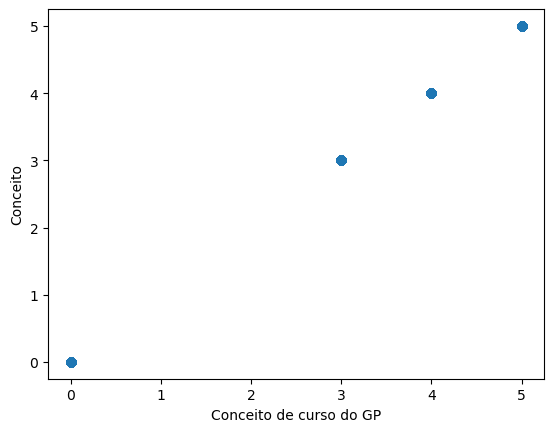

In [18]:
#Analisa relação entre os dois atributos via gráfico de dispersão.
plt.xlabel("Conceito de curso do GP")
plt.ylabel("Conceito")
plt.scatter(x = df_fies['Conceito de curso do GP'], y = df_fies['Conceito'])
plt.show()

In [19]:
#Há coincidência de pontos em todas as ocorrências, bem como a correlação é perfeita.
#Apenas um dos atributos é necessário para o algoritmo de clusterização. Se elimina uma das colunas devido à redundância.
del df_fies['Conceito de curso do GP']

In [20]:
#Analisa valores únicos da coluna para tentar entender seu significado.
df_fies['Grau'].value_counts()

SEMESTRAL     105875
ANUAL           1978
TRIMESTRAL        39
Name: Grau, dtype: int64

In [21]:
#Observa-se que 98% das ocorrências são para o valor semestral, o que indica baixa variância dos valores da coluna.
#Tomando como premissa que esse dado não seria um fator relevante para a escolha do curso pelo candidato;
#como seria por exemplo a duração do curso ou valor (atributos inexistentes na base), optou-se por eliminar o atributo.
del df_fies['Grau']

In [22]:
# Verifica em quantas linhas há coincidência entre a média nota ENEM e a soma das 5 notas individuais dividida por 5
# Há diferenças de centavos ocasionado por arredondamento em algumas linhas, portanto será considerado que não há coincidência apenas quando a diferença for superior a R$1
linhas_filtro_df = abs(df_fies['Média nota Enem'] - ((df_fies['Redação'] + 
                                                      df_fies['Matemática e suas Tecnologias'] +
                                                      df_fies['Linguagens, Códigos e suas Tec'] +
                                                      df_fies['Ciências Natureza e suas Tec'] +
                                                      df_fies['Ciências Humanas e suas Tec']) / 5)) <= 1
df_fies[linhas_filtro_df].describe()

Ano conclusão ensino médio  Nº de membros Grupo Familiar  \
count               107892.000000                 107892.000000   
mean                  2014.658260                      1.888453   
std                      5.330403                      1.274157   
min                   1969.000000                      0.000000   
25%                   2013.000000                      1.000000   
50%                   2017.000000                      2.000000   
75%                   2018.000000                      3.000000   
max                   2020.000000                     13.000000   

       Renda familiar mensal bruta  Renda mensal bruta per capita  \
count                 93709.000000                  107892.000000   
mean                   3216.280249                    1083.532818   
std                    2556.110912                     665.557121   
min                       0.000000                       0.000000   
25%                    1500.000000                     575.430000   
50%                    2393.000000                     985.000000   
75%                    3945.000000                    1379.662500   
max                   31485.810000                    7805.530000   

       Nota Corte Grupo Preferência       Conceito  Média nota Enem  \
count                 107892.000000  107892.000000    107892.000000   
mean                     616.222029       3.581850       564.644377   
std                       88.880758       1.277432        78.171866   
min                      450.040000       0.000000       450.000000   
25%                      552.680000       3.000000       502.860000   
50%                      594.000000       4.000000       545.440000   
75%                      721.380000       4.000000       617.420000   
max                      775.040000       5.000000       799.840000   

         Ano do Enem        Redação  Matemática e suas Tecnologias  \
count  107892.000000  107892.000000                  107892.000000   
mean     2017.699700     664.523968                     548.097020   
std         2.293347     156.306157                     111.283458   
min      2010.000000     120.000000                     292.800000   
25%      2017.000000     560.000000                     460.300000   
50%      2019.000000     640.000000                     532.000000   
75%      2019.000000     780.000000                     625.725000   
max      2020.000000    1000.000000                     974.800000   

       Linguagens, Códigos e suas Tec  Ciências Natureza e suas Tec  \
count                   107892.000000                 107892.000000   
mean                       541.550676                    512.039929   
std                         57.190254                     79.367501   
min                          0.000000                    281.500000   
25%                        504.400000                    451.000000   
50%                        541.500000                    505.200000   
75%                        580.400000                    567.800000   
max                        763.700000                    847.100000   

       Ciências Humanas e suas Tec  
count                107892.000000  
mean                    557.010290  
std                      76.298547  
min                       0.000000  
25%                     504.400000  
50%                     558.900000  
75%                     611.800000  
max                     840.400000

In [23]:
#Como para todas as linhas se confirmou que a coluna Média nota Enem é a média aritmética das outras 5 notas
#E também que não há nenhuma nota média de ENEM inferior a 450 (nota mínima exigida pelo FIES)
#Será eliminada a coluna, pois é redundante
del df_fies['Média nota Enem']

# Transformação de dados

In [24]:
#Observa formato carregado da data de nascimento. O ano possui apenas dois dígitos, porém há datas em séculos diferentes.
df_fies['Data de Nascimento'].head

<bound method NDFrame.head of 0         15/12/02
1         26/06/74
5         14/06/99
7         04/02/00
9         17/12/99
            ...   
212393    08/04/83
212395    12/08/01
212399    07/02/94
212402    31/05/01
212403    19/08/01
Name: Data de Nascimento, Length: 107892, dtype: object>

In [25]:
#Converte a data de nascimento para o tipo datetime64 em vez de object
df_fies['Data de Nascimento'] =  pd.to_datetime(df_fies['Data de Nascimento'], infer_datetime_format=True)
#Mostra as datas de nascimento ordenadas pelas mais recentes; há datas com anos maiores que 2020.
#Ocorreu o Bug do Milênio ao converter a string para datetime64
df_fies.sort_values('Data de Nascimento', ascending=False)['Data de Nascimento'].head

<bound method NDFrame.head of 22931    2072-12-31
2007     2072-12-30
98994    2072-12-30
154196   2072-12-27
195748   2072-12-26
            ...    
104355   1973-01-12
23340    1973-01-12
56225    1973-01-11
181162   1973-01-08
28166    1973-01-02
Name: Data de Nascimento, Length: 107892, dtype: datetime64[ns]>

In [26]:
# Para corrigir o bug do milênio na conversão de data do ano com 2 dígitos, foram subtraídos 100 anos das datas de
# nascimento superiores ao ano da oferta do FIES (2020)
cutoff_date = pd.to_datetime('01-01-2020')
df_fies.loc[df_fies['Data de Nascimento'] > cutoff_date, 'Data de Nascimento'] -= pd.DateOffset(years=100)
# lista novamente as datas ordenadas para certificar que não há nenhuma superior a 2020
df_fies.sort_values('Data de Nascimento', ascending=False)['Data de Nascimento'].head

<bound method NDFrame.head of 119989   2014-03-04
109419   2004-12-01
37552    2004-11-02
173470   2004-08-06
158469   2004-06-29
            ...    
186810   1952-12-17
141836   1952-03-11
96823    1951-11-14
190174   1950-02-10
11347    1946-07-22
Name: Data de Nascimento, Length: 107892, dtype: datetime64[ns]>

In [27]:
#Remove registros em que a data de nascimento é maior ou igual ao ano de conclusão do ensino médio (neste caso há erro nos dados)
df_fies.drop(df_fies[df_fies['Data de Nascimento'].dt.year >= df_fies['Ano conclusão ensino médio']].index, inplace=True)
len(df_fies.index)
#Apenas 1 registro removido

107891

In [28]:
#Remove registros cuja ano de nascimento seja maior ou igual ao ano do ENEM (neste caso há erro nos dados)
df_fies.drop(df_fies[df_fies['Data de Nascimento'].dt.year >= df_fies['Ano do Enem']].index, inplace=True)
len(df_fies.index)
#Nenhum registro foi removido

107891

In [29]:
#Calcula a idade do candidato em anos quando a inscrição ao FIES 2020/2 foi aberta (09/08/2020)
df_fies['Idade'] = ((pd.to_datetime('09/08/2020', dayfirst=True) - df_fies['Data de Nascimento'])/365).dt.days
#Uma vez que a idade já foi calculada, a Data de nascimento passa a ser redundante e pode ser eliminada
del df_fies['Data de Nascimento']

# Análise Exploratória

Usou-se o método describe para obter uma visão descritiva das estatísticas do DF em busca de algo estranho

In [30]:
df_latlong_mun.describe(include='all')
#Nada estranho. 
#Latitude dentro da faixa [-90..90]
#Longitude dentro da faixa [-180..180].
#Os dados estatísticos das colunas numéricas do SIAFI e IBGE não são relevantes pois os dados são categóricos nominais.
#Há duplicidade de nomes de municípios já era esperada, tendo em vista que há municípios de mesmo nome em UF distintas.

codigo_ibge       nome     latitude    longitude     siafi_id
count   5.570000e+03       5570  5570.000000  5570.000000  5570.000000
unique           NaN       5299          NaN          NaN          NaN
top              NaN  Bom Jesus          NaN          NaN          NaN
freq             NaN          5          NaN          NaN          NaN
mean    3.253591e+06        NaN   -16.449101   -46.231012  4519.878276
std     9.849103e+05        NaN     8.287274     6.408578  3050.156056
min     1.100015e+06        NaN   -33.686600   -72.899700     1.000000
25%     2.512126e+06        NaN   -22.843875   -50.878525  1595.500000
50%     3.146280e+06        NaN   -18.094300   -46.523200  4382.000000
75%     4.119190e+06        NaN    -8.496445   -41.410775  7180.500000
max     5.300108e+06        NaN     4.603140   -32.410700  9997.000000

In [31]:
df_stn_mun.describe(include='all')
#Nada estranho. 
#Os dados estatísticos das colunas numéricas do SIAFI e IBGE não são relevantes pois os dados são categóricos nominais.
#Há duplicidade de nomes de municípios já era esperada, tendo em vista que há municípios de mesmo nome em UF distintas.

siafi_id                                       nome_mun sigla_uf  \
count   5589.000000                                           5589     5589   
unique          NaN                                           5292       27   
top             NaN  DEMAIS MUNICIPIOS                                   MG   
freq            NaN                                             19      854   
mean    4522.997674                                            NaN      NaN   
std     3050.440871                                            NaN      NaN   
min        1.000000                                            NaN      NaN   
25%     1601.000000                                            NaN      NaN   
50%     4383.000000                                            NaN      NaN   
75%     7185.000000                                            NaN      NaN   
max     9997.000000                                            NaN      NaN   

         codigo_ibge  
count   5.589000e+03  
unique           NaN  
top              NaN  
freq             NaN  
mean    3.242530e+06  
std     1.001310e+06  
min     0.000000e+00  
25%     2.510907e+06  
50%     3.145604e+06  
75%     4.118857e+06  
max     5.300108e+06

In [32]:
#Analisa primeiro as colunas numéricas.
df_fies.describe()
#Faixa de idade: [15..74], sem valores absurdos (ex.: <=0 ou >100)
#Faixa de ano para conclusão ensino médio: [1969..2020], sem valores absurdos (>2020, superior ao ano da oferta do FIES), o menor ano é do candidato com maior idade
#Faixa de número de membros do grupo familiar: [0..13], sem valores absurdos (ex.: <=0 ou >20)
#Faixa notas do ENEM, sem valores absurdos (ex.: <=450 ou >1.000)
#Faixa do ano do ENEM: [2010..2020], sem valores absurdos (>2020, superior ao ano da oferta do FIES)
#Não há regra entre o ano do ENEM que o candidato prestou o exame e o ano de conclusão do ensino médio. Treineiros podem fazer o ENEM antes de concluir o ensino médio.
#Há algo estranho para o número de membros do grupo familiar com valor zero
#Há algo estranho entre a quantidade de linhas da renda familiar e da renda per capita

Ano conclusão ensino médio  Nº de membros Grupo Familiar  \
count               107891.000000                 107891.000000   
mean                  2014.658294                      1.888424   
std                      5.330417                      1.274128   
min                   1969.000000                      0.000000   
25%                   2013.000000                      1.000000   
50%                   2017.000000                      2.000000   
75%                   2018.000000                      3.000000   
max                   2020.000000                     13.000000   

       Renda familiar mensal bruta  Renda mensal bruta per capita  \
count                 93708.000000                  107891.000000   
mean                   3216.290614                    1083.539393   
std                    2556.122581                     665.556702   
min                       0.000000                       0.000000   
25%                    1500.000000                     575.520000   
50%                    2393.025000                     985.000000   
75%                    3945.000000                    1379.685000   
max                   31485.810000                    7805.530000   

       Nota Corte Grupo Preferência       Conceito    Ano do Enem  \
count                 107891.000000  107891.000000  107891.000000   
mean                     616.222259       3.581846    2017.699688   
std                       88.881138       1.277438       2.293354   
min                      450.040000       0.000000    2010.000000   
25%                      552.680000       3.000000    2017.000000   
50%                      594.000000       4.000000    2019.000000   
75%                      721.380000       4.000000    2019.000000   
max                      775.040000       5.000000    2020.000000   

             Redação  Matemática e suas Tecnologias  \
count  107891.000000                  107891.000000   
mean      664.523640                     548.097571   
std       156.306844                     111.283826   
min       120.000000                     292.800000   
25%       560.000000                     460.300000   
50%       640.000000                     532.000000   
75%       780.000000                     625.750000   
max      1000.000000                     974.800000   

       Linguagens, Códigos e suas Tec  Ciências Natureza e suas Tec  \
count                   107891.000000                 107891.000000   
mean                       541.549777                    512.039443   
std                         57.189757                     79.367708   
min                          0.000000                    281.500000   
25%                        504.400000                    451.000000   
50%                        541.500000                    505.200000   
75%                        580.400000                    567.800000   
max                        763.700000                    847.100000   

       Ciências Humanas e suas Tec          Idade  
count                107891.000000  107891.000000  
mean                    557.009821      23.374155  
std                      76.298745       6.534021  
min                       0.000000      15.000000  
25%                     504.400000      19.000000  
50%                     558.900000      21.000000  
75%                     611.800000      25.000000  
max                     840.400000      74.000000

In [33]:
# Sobre o  Nº de membros Grupo Familiar 
# Não há valores nulos na coluna (a quantidade de valores da coluna é igual à quantidade de linhas do dataframe).
df_fies[df_fies['Nº de membros Grupo Familiar'] == 0].describe()
# Em todos estes casos a renda familiar é NAN, porém há valores na renda per capita.
# Isto indica que o MEC não considera o próprio candidato como parte do número de membros do grupo familiar

Ano conclusão ensino médio  Nº de membros Grupo Familiar  \
count                14183.000000                       14183.0   
mean                  2013.186773                           0.0   
std                      5.746221                           0.0   
min                   1969.000000                           0.0   
25%                   2011.000000                           0.0   
50%                   2015.000000                           0.0   
75%                   2017.000000                           0.0   
max                   2020.000000                           0.0   

       Renda familiar mensal bruta  Renda mensal bruta per capita  \
count                          0.0                   14183.000000   
mean                           NaN                    1430.816121   
std                            NaN                     522.072079   
min                            NaN                       0.000000   
25%                            NaN                    1045.000000   
50%                            NaN                    1200.000000   
75%                            NaN                    1551.000000   
max                            NaN                    5184.450000   

       Nota Corte Grupo Preferência      Conceito   Ano do Enem       Redação  \
count                  14183.000000  14183.000000  14183.000000  14183.000000   
mean                     616.786143      3.553550   2017.031587    643.375520   
std                       88.003052      1.270026      2.514404    152.967313   
min                      450.040000      0.000000   2010.000000    200.000000   
25%                      553.860000      3.000000   2016.000000    540.000000   
50%                      595.420000      4.000000   2018.000000    620.000000   
75%                      720.960000      4.000000   2019.000000    760.000000   
max                      775.040000      5.000000   2020.000000   1000.000000   

       Matemática e suas Tecnologias  Linguagens, Códigos e suas Tec  \
count                    14183.00000                    14183.000000   
mean                       542.69058                      538.629549   
std                        111.09649                       59.167558   
min                        293.40000                      319.600000   
25%                        455.80000                      499.600000   
50%                        526.70000                      538.300000   
75%                        617.50000                      579.400000   
max                        974.80000                      748.400000   

       Ciências Natureza e suas Tec  Ciências Humanas e suas Tec         Idade  
count                  14183.000000                 14183.000000  14183.000000  
mean                     513.057350                   559.840302     25.355426  
std                       78.926388                    75.582751      6.995623  
min                      281.500000                   320.800000     16.000000  
25%                      452.850000                   508.700000     20.000000  
50%                      506.000000                   562.200000     23.000000  
75%                      567.700000                   613.200000     28.000000  
max                      797.900000                   814.200000     74.000000

In [34]:
# Verificação em sentido inverso, de que para todas as linhas cuja renda familiar é NAN, o número de membros do grupo familiar é zero.
# Isso indica que a renda familiar mensal é informada apenas quando há outros membros no grupo familiar.
# Observa-se também que a renda per capita média não é zero, o que indica que a renda per capita computa a renda do candidato e a renda familiar não.
df_fies[df_fies['Renda familiar mensal bruta'].isna()].describe()

Ano conclusão ensino médio  Nº de membros Grupo Familiar  \
count                14183.000000                       14183.0   
mean                  2013.186773                           0.0   
std                      5.746221                           0.0   
min                   1969.000000                           0.0   
25%                   2011.000000                           0.0   
50%                   2015.000000                           0.0   
75%                   2017.000000                           0.0   
max                   2020.000000                           0.0   

       Renda familiar mensal bruta  Renda mensal bruta per capita  \
count                          0.0                   14183.000000   
mean                           NaN                    1430.816121   
std                            NaN                     522.072079   
min                            NaN                       0.000000   
25%                            NaN                    1045.000000   
50%                            NaN                    1200.000000   
75%                            NaN                    1551.000000   
max                            NaN                    5184.450000   

       Nota Corte Grupo Preferência      Conceito   Ano do Enem       Redação  \
count                  14183.000000  14183.000000  14183.000000  14183.000000   
mean                     616.786143      3.553550   2017.031587    643.375520   
std                       88.003052      1.270026      2.514404    152.967313   
min                      450.040000      0.000000   2010.000000    200.000000   
25%                      553.860000      3.000000   2016.000000    540.000000   
50%                      595.420000      4.000000   2018.000000    620.000000   
75%                      720.960000      4.000000   2019.000000    760.000000   
max                      775.040000      5.000000   2020.000000   1000.000000   

       Matemática e suas Tecnologias  Linguagens, Códigos e suas Tec  \
count                    14183.00000                    14183.000000   
mean                       542.69058                      538.629549   
std                        111.09649                       59.167558   
min                        293.40000                      319.600000   
25%                        455.80000                      499.600000   
50%                        526.70000                      538.300000   
75%                        617.50000                      579.400000   
max                        974.80000                      748.400000   

       Ciências Natureza e suas Tec  Ciências Humanas e suas Tec         Idade  
count                  14183.000000                 14183.000000  14183.000000  
mean                     513.057350                   559.840302     25.355426  
std                       78.926388                    75.582751      6.995623  
min                      281.500000                   320.800000     16.000000  
25%                      452.850000                   508.700000     20.000000  
50%                      506.000000                   562.200000     23.000000  
75%                      567.700000                   613.200000     28.000000  
max                      797.900000                   814.200000     74.000000

In [35]:
#Verifica o número de membros do grupo familiar quando a renda familiar é zero.
#Há 21 ocorrências, e em todas o número de membros familiares é maior que zero e renda per capita é zero.
#Isso indica que o candidato informou membros da família, maior de 14 anos e sem renda.
df_fies[df_fies['Renda familiar mensal bruta'] == 0].describe()

Ano conclusão ensino médio  Nº de membros Grupo Familiar  \
count                   14.000000                     14.000000   
mean                  2015.357143                      1.785714   
std                      4.797550                      0.699293   
min                   2001.000000                      1.000000   
25%                   2014.500000                      1.000000   
50%                   2017.000000                      2.000000   
75%                   2017.750000                      2.000000   
max                   2019.000000                      3.000000   

       Renda familiar mensal bruta  Renda mensal bruta per capita  \
count                         14.0                           14.0   
mean                           0.0                            0.0   
std                            0.0                            0.0   
min                            0.0                            0.0   
25%                            0.0                            0.0   
50%                            0.0                            0.0   
75%                            0.0                            0.0   
max                            0.0                            0.0   

       Nota Corte Grupo Preferência   Conceito  Ano do Enem     Redação  \
count                     14.000000  14.000000    14.000000   14.000000   
mean                     543.968571   3.357143  2017.928571  627.142857   
std                       50.364617   1.598420     2.464027   96.271137   
min                      476.000000   0.000000  2011.000000  460.000000   
25%                      509.425000   3.000000  2017.000000  600.000000   
50%                      549.760000   4.000000  2019.000000  620.000000   
75%                      564.730000   4.000000  2019.750000  675.000000   
max                      651.000000   5.000000  2020.000000  820.000000   

       Matemática e suas Tecnologias  Linguagens, Códigos e suas Tec  \
count                      14.000000                       14.000000   
mean                      541.778571                      538.078571   
std                        80.976314                       38.178209   
min                       389.900000                      476.700000   
25%                       503.800000                      505.575000   
50%                       562.850000                      541.000000   
75%                       599.325000                      561.475000   
max                       646.000000                      598.700000   

       Ciências Natureza e suas Tec  Ciências Humanas e suas Tec      Idade  
count                     14.000000                    14.000000  14.000000  
mean                     494.750000                   532.107143  22.071429  
std                       53.671031                    36.496206   4.714369  
min                      417.400000                   459.700000  18.000000  
25%                      453.150000                   518.650000  19.250000  
50%                      497.150000                   530.600000  20.000000  
75%                      524.575000                   548.750000  23.750000  
max                      596.300000                   609.200000  36.000000

In [36]:
#Verifica em quantas linhas há coincidência entre a renda familiar e a renda per capita multiplicada pelo número de membros.
linhas_filtro_df = round(df_fies['Renda familiar mensal bruta'],2) == round(df_fies['Renda mensal bruta per capita'] * df_fies['Nº de membros Grupo Familiar'],2)
df_fies[linhas_filtro_df][['Nº de membros Grupo Familiar', 'Renda familiar mensal bruta', 'Renda mensal bruta per capita']].describe()
#A coincidência existe apenas quando ambas as colunas estão zeradas, o que indica que o candidato não compõe o número de membros.

Nº de membros Grupo Familiar  Renda familiar mensal bruta  \
count                     14.000000                         14.0   
mean                       1.785714                          0.0   
std                        0.699293                          0.0   
min                        1.000000                          0.0   
25%                        1.000000                          0.0   
50%                        2.000000                          0.0   
75%                        2.000000                          0.0   
max                        3.000000                          0.0   

       Renda mensal bruta per capita  
count                           14.0  
mean                             0.0  
std                              0.0  
min                              0.0  
25%                              0.0  
50%                              0.0  
75%                              0.0  
max                              0.0

In [37]:
#Preenche a coluna renda familiar com zeros caso o valor seja nulo (neste caso o número de membros do grupo já é zero)
df_fies['Renda familiar mensal bruta'].fillna(0, inplace=True)
#Verifica total de linhas cuja renda familiar é zero
#Deveria ser a soma dos NAN (27.077) e os de zero (21), confere!
df_fies[df_fies['Renda familiar mensal bruta'] == 0].describe()

Ano conclusão ensino médio  Nº de membros Grupo Familiar  \
count                14197.000000                  14197.000000   
mean                  2013.188913                      0.001761   
std                      5.745625                      0.059912   
min                   1969.000000                      0.000000   
25%                   2011.000000                      0.000000   
50%                   2015.000000                      0.000000   
75%                   2017.000000                      0.000000   
max                   2020.000000                      3.000000   

       Renda familiar mensal bruta  Renda mensal bruta per capita  \
count                      14197.0                   14197.000000   
mean                           0.0                    1429.405159   
std                            0.0                     523.743676   
min                            0.0                       0.000000   
25%                            0.0                    1045.000000   
50%                            0.0                    1200.000000   
75%                            0.0                    1550.000000   
max                            0.0                    5184.450000   

       Nota Corte Grupo Preferência      Conceito   Ano do Enem       Redação  \
count                  14197.000000  14197.000000  14197.000000  14197.000000   
mean                     616.714335      3.553356   2017.032472    643.359513   
std                       88.002537      1.270336      2.514428    152.920469   
min                      450.040000      0.000000   2010.000000    200.000000   
25%                      553.820000      3.000000   2016.000000    540.000000   
50%                      595.420000      4.000000   2018.000000    620.000000   
75%                      719.720000      4.000000   2019.000000    760.000000   
max                      775.040000      5.000000   2020.000000   1000.000000   

       Matemática e suas Tecnologias  Linguagens, Códigos e suas Tec  \
count                   14197.000000                    14197.000000   
mean                      542.689681                      538.629006   
std                       111.068734                       59.149662   
min                       293.400000                      319.600000   
25%                       455.800000                      499.600000   
50%                       526.700000                      538.300000   
75%                       617.500000                      579.400000   
max                       974.800000                      748.400000   

       Ciências Natureza e suas Tec  Ciências Humanas e suas Tec         Idade  
count                  14197.000000                 14197.000000  14197.000000  
mean                     513.039297                   559.812953     25.352187  
std                       78.906270                    75.558559      6.994388  
min                      281.500000                   320.800000     16.000000  
25%                      452.800000                   508.700000     20.000000  
50%                      505.900000                   562.100000     23.000000  
75%                      567.600000                   613.100000     28.000000  
max                      797.900000                   814.200000     74.000000

In [38]:
#Verifica em quantos registros há renda familiar menor que a renda per capita.
linhas_filtro_df = round(df_fies['Renda familiar mensal bruta'],2) < round(df_fies['Renda mensal bruta per capita'],2)
df_fies[linhas_filtro_df][['Nº de membros Grupo Familiar', 'Renda familiar mensal bruta', 'Renda mensal bruta per capita']].describe()
#Em todas as ocorrências a renda familiar é zero, o que indica que a renda do candidato não compõe a renda familiar.

Nº de membros Grupo Familiar  Renda familiar mensal bruta  \
count                       14166.0                      14166.0   
mean                            0.0                          0.0   
std                             0.0                          0.0   
min                             0.0                          0.0   
25%                             0.0                          0.0   
50%                             0.0                          0.0   
75%                             0.0                          0.0   
max                             0.0                          0.0   

       Renda mensal bruta per capita  
count                   14166.000000  
mean                     1432.533181  
std                       520.025428  
min                        12.000000  
25%                      1045.000000  
50%                      1200.000000  
75%                      1553.622500  
max                      5184.450000

In [39]:
#Verifica em quantas linhas há coincidência entre a renda familiar e a renda percapita multiplicada pelo número de membros + 1 (o próprio candidato)
#Há diferenças de centavos ocasionado por arredondamento em algumas linhas, portanto será considerado que não há coincidência apenas quando a diferença for superior a R$1
linhas_filtro_df = abs(df_fies['Renda familiar mensal bruta'] - df_fies['Renda mensal bruta per capita'] * (df_fies['Nº de membros Grupo Familiar']+1)) <= 1
df_fies[linhas_filtro_df][['Nº de membros Grupo Familiar', 'Renda familiar mensal bruta', 'Renda mensal bruta per capita']].describe()

Nº de membros Grupo Familiar  Renda familiar mensal bruta  \
count                  93725.000000                 93725.000000   
mean                       2.173849                  3215.707238   
std                        1.117272                  2556.257718   
min                        0.000000                     0.000000   
25%                        1.000000                  1500.000000   
50%                        2.000000                  2392.000000   
75%                        3.000000                  3945.000000   
max                       13.000000                 31485.810000   

       Renda mensal bruta per capita  
count                   93725.000000  
mean                     1030.790969  
std                       669.220234  
min                         0.000000  
25%                       530.000000  
50%                       833.330000  
75%                      1321.510000  
max                      7805.530000

In [40]:
# Investiga a situação dos registros em que não há a coincidência anterior
linhas_filtro_df = abs(df_fies['Renda familiar mensal bruta'] - df_fies['Renda mensal bruta per capita'] * (df_fies['Nº de membros Grupo Familiar']+1)) > 1
df_fies[linhas_filtro_df][['Nº de membros Grupo Familiar', 'Renda familiar mensal bruta', 'Renda mensal bruta per capita']].describe()
# Em todas elas a renda familiar e o número de membros estão zerados
# Se consideramos a tamanho da família somente o próprio candidato, a renda familiar seria equivalente à renda per capita
# logo a renda familiar é uma informação redundante, derivada do número de membros e a renda per capita, 
# podendo ser desprezada no modelo de machine learning.

Nº de membros Grupo Familiar  Renda familiar mensal bruta  \
count                       14166.0                      14166.0   
mean                            0.0                          0.0   
std                             0.0                          0.0   
min                             0.0                          0.0   
25%                             0.0                          0.0   
50%                             0.0                          0.0   
75%                             0.0                          0.0   
max                             0.0                          0.0   

       Renda mensal bruta per capita  
count                   14166.000000  
mean                     1432.533181  
std                       520.025428  
min                        12.000000  
25%                      1045.000000  
50%                      1200.000000  
75%                      1553.622500  
max                      5184.450000

In [41]:
# Renda familiar mensal bruta é dado redundante (renda per capita x número membros família), atributo pode ser eliminado
del df_fies['Renda familiar mensal bruta']

In [42]:
#Reanalisa  as colunas numéricas após o processamento anterior.
df_fies.describe()
#O candidato médio do FIES tem 23 anos, concluiu o ensino médio em 2014, vive com menos que dois familiares, cuja renda mensal per capita é 
#de R$1.083, busca um curso de conceito entre 3 e 4, cuja nota de corte é 616, sendo que sua nota do ENEM é do ano 2017 e de média 564.

Ano conclusão ensino médio  Nº de membros Grupo Familiar  \
count               107891.000000                 107891.000000   
mean                  2014.658294                      1.888424   
std                      5.330417                      1.274128   
min                   1969.000000                      0.000000   
25%                   2013.000000                      1.000000   
50%                   2017.000000                      2.000000   
75%                   2018.000000                      3.000000   
max                   2020.000000                     13.000000   

       Renda mensal bruta per capita  Nota Corte Grupo Preferência  \
count                  107891.000000                 107891.000000   
mean                     1083.539393                    616.222259   
std                       665.556702                     88.881138   
min                         0.000000                    450.040000   
25%                       575.520000                    552.680000   
50%                       985.000000                    594.000000   
75%                      1379.685000                    721.380000   
max                      7805.530000                    775.040000   

            Conceito    Ano do Enem        Redação  \
count  107891.000000  107891.000000  107891.000000   
mean        3.581846    2017.699688     664.523640   
std         1.277438       2.293354     156.306844   
min         0.000000    2010.000000     120.000000   
25%         3.000000    2017.000000     560.000000   
50%         4.000000    2019.000000     640.000000   
75%         4.000000    2019.000000     780.000000   
max         5.000000    2020.000000    1000.000000   

       Matemática e suas Tecnologias  Linguagens, Códigos e suas Tec  \
count                  107891.000000                   107891.000000   
mean                      548.097571                      541.549777   
std                       111.283826                       57.189757   
min                       292.800000                        0.000000   
25%                       460.300000                      504.400000   
50%                       532.000000                      541.500000   
75%                       625.750000                      580.400000   
max                       974.800000                      763.700000   

       Ciências Natureza e suas Tec  Ciências Humanas e suas Tec  \
count                 107891.000000                107891.000000   
mean                     512.039443                   557.009821   
std                       79.367708                    76.298745   
min                      281.500000                     0.000000   
25%                      451.000000                   504.400000   
50%                      505.200000                   558.900000   
75%                      567.800000                   611.800000   
max                      847.100000                   840.400000   

               Idade  
count  107891.000000  
mean       23.374155  
std         6.534021  
min        15.000000  
25%        19.000000  
50%        21.000000  
75%        25.000000  
max        74.000000

In [43]:
#Analisa as colunas não numéricas.
df_fies.describe(include=[object])
#O candidato médio do FIES é do sexo feminino, reside em São Paulo-SP, é de cor parda, não possui deficiência física,
#cursou o ensino médio em escola pública, nunca concluiu o curso superior nem foi professor da rede pública de ensino, deseja
#realizar o curso de Medicina na própria cidade e o turno preferido é noturno.

Sexo UF de residência Municipio de residência Etnia/Cor  \
count   107891           107891                  107891    107891   
unique       2               27                    4382         5   
top          F               SP               SÃO PAULO     PARDA   
freq     72467            15133                    3968     49498   

       Pessoa com deficiência? Tipo de escola no ensino médio  \
count                   107891                         107891   
unique                       2                              3   
top                        NÃO                            SIM   
freq                    106893                          74879   

       Concluiu curso superior? Professor rede pública ensino?  \
count                    107891                         107891   
unique                        2                              2   
top                         NÃO                            NÃO   
freq                      94989                         101737   

       Munícipio do Local de Oferta UF do Local de Oferta Nome do curso  \
count                        107891                107891        107891   
unique                          514                    27           217   
top                       SÃO PAULO                    SP      MEDICINA   
freq                           5676                 14984         29906   

          Turno  
count    107891  
unique        4  
top     NOTURNO  
freq      49463

In [44]:
df_fies['Sexo'].value_counts()

F    72467
M    35424
Name: Sexo, dtype: int64

In [45]:
df_fies['UF de residência'].value_counts()

SP    15133
MG    13964
BA     8685
CE     8049
RJ     7081
PE     5561
MA     5182
PA     4706
GO     4638
PR     4572
PB     3384
PI     3316
RS     3178
AM     2742
DF     2478
ES     1824
RN     1684
AL     1619
SC     1507
SE     1462
MT     1443
MS     1438
TO     1396
RO     1377
AP      680
AC      547
RR      245
Name: UF de residência, dtype: int64

In [46]:
df_fies['Municipio de residência'].value_counts()

SÃO PAULO                3968
FORTALEZA                2814
RIO DE JANEIRO           2535
MANAUS                   2491
BRASÍLIA                 2478
                         ... 
GURINHATÃ                   1
MATA GRANDE                 1
OLHO D¿ÁGUA DO CASADO       1
SANTA BRÍGIDA               1
FORTUNA DE MINAS            1
Name: Municipio de residência, Length: 4382, dtype: int64

In [47]:
df_fies['Etnia/Cor'].value_counts()

PARDA       49498
BRANCA      43273
PRETA       12238
AMARELA      2571
INDÍGENA      311
Name: Etnia/Cor, dtype: int64

In [48]:
df_fies['Pessoa com deficiência?'].value_counts()

NÃO    106893
SIM       998
Name: Pessoa com deficiência?, dtype: int64

In [49]:
df_fies['Tipo de escola no ensino médio'].value_counts()

SIM        74879
NÃO        26560
PARCIAL     6452
Name: Tipo de escola no ensino médio, dtype: int64

In [50]:
df_fies['Concluiu curso superior?'].value_counts()

NÃO    94989
SIM    12902
Name: Concluiu curso superior?, dtype: int64

In [51]:
df_fies['Professor rede pública ensino?'].value_counts()

NÃO    101737
SIM      6154
Name: Professor rede pública ensino?, dtype: int64

In [52]:
df_fies['Munícipio do Local de Oferta'].value_counts()

SÃO PAULO         5676
BELO HORIZONTE    3851
FORTALEZA         3540
MANAUS            3108
RIO DE JANEIRO    3088
                  ... 
CAIEIRAS             1
IÇARA                1
BELO JARDIM          1
BANDEIRANTES         1
BEBEDOURO            1
Name: Munícipio do Local de Oferta, Length: 514, dtype: int64

In [53]:
df_fies['UF do Local de Oferta'].value_counts()

SP    14984
MG    13417
BA     9146
RJ     7697
CE     7469
PR     5263
PE     5209
PA     4625
MA     4167
PB     4086
GO     3923
PI     3424
AM     3109
DF     2908
RS     2818
TO     1825
AL     1785
ES     1708
MS     1681
SC     1573
MT     1572
RO     1401
SE     1230
RN     1217
AC      808
AP      643
RR      203
Name: UF do Local de Oferta, dtype: int64

In [54]:
df_fies['Nome do curso'].value_counts()

MEDICINA                          29906
DIREITO                           14325
ENFERMAGEM                         8774
ODONTOLOGIA                        7701
PSICOLOGIA                         6389
                                  ...  
MUSICOTERAPIA                         1
PRODUÇÃO CULTURAL                     1
ENGENHARIA INDUSTRIAL MECÂNICA        1
ENGENHARIA DE PRODUÇÃO CIVIL          1
DESIGN VISUAL                         1
Name: Nome do curso, Length: 217, dtype: int64

In [55]:
df_fies['Turno'].value_counts()

NOTURNO       49463
INTEGRAL      34076
MATUTINO      21665
VESPERTINO     2687
Name: Turno, dtype: int64

In [56]:
#Elimina acentos e caracteres especiais da coluna para poder fazer o merge com dados de latitude/longitude do município pelo nome.
df_fies['Municipio de residência'] = df_fies['Municipio de residência'].apply(lambda x: unidecode(x))
df_fies['Munícipio do Local de Oferta'] = df_fies['Munícipio do Local de Oferta'].apply(lambda x: unidecode(x))
df_fies['Municipio de residência'].value_counts()

SAO PAULO                3968
FORTALEZA                2814
RIO DE JANEIRO           2535
MANAUS                   2491
BRASILIA                 2478
                         ... 
CASTELANDIA                 1
BARRA DO TURVO              1
MATA GRANDE                 1
OLHO D?AGUA DO CASADO       1
FORTUNA DE MINAS            1
Name: Municipio de residência, Length: 4376, dtype: int64

In [57]:
df_fies['Munícipio do Local de Oferta'].value_counts()

SAO PAULO         5676
BELO HORIZONTE    3851
FORTALEZA         3540
MANAUS            3108
RIO DE JANEIRO    3088
                  ... 
CAIEIRAS             1
ICARA                1
BELO JARDIM          1
BANDEIRANTES         1
BEBEDOURO            1
Name: Munícipio do Local de Oferta, Length: 514, dtype: int64

In [58]:
#O apóstofro existente no nome do município foi substituído na base original por um caracter especial.
#Provavelmente houve problema na exportação dos dados pelo MEC. Substitui o caracter especial pelo apóstofro.
df_fies['Municipio de residência'] = df_fies['Municipio de residência'].str.replace('\?', '\'')
df_fies['Munícipio do Local de Oferta'] = df_fies['Munícipio do Local de Oferta'].str.replace('\?', '\'')
df_fies['Municipio de residência'].value_counts()

C:\Users\guilh\AppData\Local\Temp\ipykernel_18248\724110791.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df_fies['Municipio de residência'] = df_fies['Municipio de residência'].str.replace('\?', '\'')
C:\Users\guilh\AppData\Local\Temp\ipykernel_18248\724110791.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df_fies['Munícipio do Local de Oferta'] = df_fies['Munícipio do Local de Oferta'].str.replace('\?', '\'')


SAO PAULO                3968
FORTALEZA                2814
RIO DE JANEIRO           2535
MANAUS                   2491
BRASILIA                 2478
                         ... 
CASTELANDIA                 1
BARRA DO TURVO              1
MATA GRANDE                 1
OLHO D'AGUA DO CASADO       1
FORTUNA DE MINAS            1
Name: Municipio de residência, Length: 4376, dtype: int64

In [59]:
#Analisa qual a incidência de casos onde o candidato seleciona um curso ofertado num município diferente do de sua residência.
#Se a coincidência for alta, indica que um dos atributos poderia ser desprezado.
linhas_filtro_df = df_fies['Municipio de residência'] != df_fies['Munícipio do Local de Oferta']
df_fies[linhas_filtro_df][['Municipio de residência','Munícipio do Local de Oferta']].describe()
#Porém não é o que acontece, em mais da metade dos casos o candidato seleciona um curso em um município diferente
#do município de sua residência. Logo os dois atributos serão mantidos.

Municipio de residência Munícipio do Local de Oferta
count                    57310                        57310
unique                    4376                          491
top                    GOIANIA                    SAO PAULO
freq                       609                         2235

# Enriquecimento dos dados

In [60]:
#Mescla dados de município latitude/longitude com lista siafie/ibge para obter a sigla UF
df_mun_merged = pd.merge(df_latlong_mun, df_stn_mun, on=['siafi_id', 'codigo_ibge'], how='inner')
df_mun_merged

codigo_ibge                 nome  latitude  longitude  siafi_id  \
0         5200050      Abadia de Goiás -16.75730   -49.4412      1050   
1         3100104  Abadia dos Dourados -18.48310   -47.3916      4001   
2         5200100            Abadiânia -16.19700   -48.7057      9201   
3         3100203               Abaeté -19.15510   -45.4444      4003   
4         1500107           Abaetetuba  -1.72183   -48.8788       401   
...           ...                  ...       ...        ...       ...   
5565      2933604          Xique-Xique -10.82300   -42.7245      3971   
5566      2517407               Zabelê  -8.07901   -37.1057       542   
5567      3557154             Zacarias -21.05060   -50.0552      2973   
5568      2114007              Zé Doca  -3.27014   -45.6553      1287   
5569      4219853               Zortéa -27.45210   -51.5520       950   

                                           nome_mun sigla_uf  
0     ABADIA DE GOIAS                                     GO  
1     ABADIA DOS DOURADOS                                 MG  
2     ABADIANIA                                           GO  
3     ABAETE                                              MG  
4     ABAETETUBA                                          PA  
...                                             ...      ...  
5565  XIQUE-XIQUE                                         BA  
5566  ZABELE                                              PB  
5567  ZACARIAS                                            SP  
5568  ZE DOCA                                             MA  
5569  ZORTEA                                              SC  

[5570 rows x 7 columns]

In [61]:
#Elimina as colunas de código IBGE, id SIAFI e do nome com acentuação que não são mais necessárias.
#E transforma coluna do nome acentuado também para maiúscula, eliminando espaços antes e depois do nome.
del df_mun_merged['codigo_ibge']
del df_mun_merged['siafi_id']
del df_mun_merged['nome']
df_mun_merged['nome_mun'] = df_mun_merged['nome_mun'].str.strip().str.upper()
#Elimina acentos e caracteres especiais da coluna para poder fazer o merge com dados de lat long do município pelo nome
df_mun_merged['nome_mun'] = df_mun_merged['nome_mun'].apply(lambda x: unidecode(x))
df_mun_merged

latitude  longitude             nome_mun sigla_uf
0    -16.75730   -49.4412      ABADIA DE GOIAS       GO
1    -18.48310   -47.3916  ABADIA DOS DOURADOS       MG
2    -16.19700   -48.7057            ABADIANIA       GO
3    -19.15510   -45.4444               ABAETE       MG
4     -1.72183   -48.8788           ABAETETUBA       PA
...        ...        ...                  ...      ...
5565 -10.82300   -42.7245          XIQUE-XIQUE       BA
5566  -8.07901   -37.1057               ZABELE       PB
5567 -21.05060   -50.0552             ZACARIAS       SP
5568  -3.27014   -45.6553              ZE DOCA       MA
5569 -27.45210   -51.5520               ZORTEA       SC

[5570 rows x 4 columns]

## Enriquecendo dados de município de residência

In [62]:
#Renomeia colunas para fazer o merge com os dados de município de residencia do candidato do fies
df_mun_merged.rename(columns={'nome_mun': 'Municipio de residência', 'sigla_uf': 'UF de residência'}, inplace=True)
df_mun_merged

latitude  longitude Municipio de residência UF de residência
0    -16.75730   -49.4412         ABADIA DE GOIAS               GO
1    -18.48310   -47.3916     ABADIA DOS DOURADOS               MG
2    -16.19700   -48.7057               ABADIANIA               GO
3    -19.15510   -45.4444                  ABAETE               MG
4     -1.72183   -48.8788              ABAETETUBA               PA
...        ...        ...                     ...              ...
5565 -10.82300   -42.7245             XIQUE-XIQUE               BA
5566  -8.07901   -37.1057                  ZABELE               PB
5567 -21.05060   -50.0552                ZACARIAS               SP
5568  -3.27014   -45.6553                 ZE DOCA               MA
5569 -27.45210   -51.5520                  ZORTEA               SC

[5570 rows x 4 columns]

In [63]:
#Mescla dados do FIES com latitude e longitude do município de residência do candidato
df_fies_merged = pd.merge(df_fies, df_mun_merged, on=['Municipio de residência', 'UF de residência'], how='left')
df_fies_merged.describe(include='all')
#Pela quantidade de linhas não nulas de latitude e longitude, observa-se que não se encontrou dados para todos os municípios

Sexo UF de residência Municipio de residência Etnia/Cor  \
count   107891           107891                  107891    107891   
unique       2               27                    4376         5   
top          F               SP               SAO PAULO     PARDA   
freq     72467            15133                    3968     49498   
mean       NaN              NaN                     NaN       NaN   
std        NaN              NaN                     NaN       NaN   
min        NaN              NaN                     NaN       NaN   
25%        NaN              NaN                     NaN       NaN   
50%        NaN              NaN                     NaN       NaN   
75%        NaN              NaN                     NaN       NaN   
max        NaN              NaN                     NaN       NaN   

       Pessoa com deficiência? Tipo de escola no ensino médio  \
count                   107891                         107891   
unique                       2                              3   
top                        NÃO                            SIM   
freq                    106893                          74879   
mean                       NaN                            NaN   
std                        NaN                            NaN   
min                        NaN                            NaN   
25%                        NaN                            NaN   
50%                        NaN                            NaN   
75%                        NaN                            NaN   
max                        NaN                            NaN   

        Ano conclusão ensino médio Concluiu curso superior?  \
count                107891.000000                   107891   
unique                         NaN                        2   
top                            NaN                      NÃO   
freq                           NaN                    94989   
mean                   2014.658294                      NaN   
std                       5.330417                      NaN   
min                    1969.000000                      NaN   
25%                    2013.000000                      NaN   
50%                    2017.000000                      NaN   
75%                    2018.000000                      NaN   
max                    2020.000000                      NaN   

       Professor rede pública ensino?  Nº de membros Grupo Familiar  ...  \
count                          107891                 107891.000000  ...   
unique                              2                           NaN  ...   
top                               NÃO                           NaN  ...   
freq                           101737                           NaN  ...   
mean                              NaN                      1.888424  ...   
std                               NaN                      1.274128  ...   
min                               NaN                      0.000000  ...   
25%                               NaN                      1.000000  ...   
50%                               NaN                      2.000000  ...   
75%                               NaN                      3.000000  ...   
max                               NaN                     13.000000  ...   

             Conceito    Ano do Enem        Redação  \
count   107891.000000  107891.000000  107891.000000   
unique            NaN            NaN            NaN   
top               NaN            NaN            NaN   
freq              NaN            NaN            NaN   
mean         3.581846    2017.699688     664.523640   
std          1.277438       2.293354     156.306844   
min          0.000000    2010.000000     120.000000   
25%          3.000000    2017.000000     560.000000   
50%          4.000000    2019.000000     640.000000   
75%          4.000000    2019.000000     780.000000   
max          5.000000    2020.000000    1000.000000   

       Matemática e suas Tecnologias Linguagens, Códigos e suas Tec  

In [64]:
#Verifica quais são os municípios onde não se achou lat long
df_fies_merged[df_fies_merged['latitude'].isnull()][['Municipio de residência','UF de residência']].value_counts()

Municipio de residência  UF de residência
MOJI MIRIM               SP                  16
AUGUSTO SEVERO           RN                   3
SANTAREM                 PB                   3
CAMPO DE SANTANA         PB                   2
ABDON BATISTA            PR                   1
PRESIDENTE JUSCELINO     RN                   1
dtype: int64

In [65]:
#Correção de erro de grafia no nome do município
df_fies.loc[df_fies['Municipio de residência'] == 'MOJI MIRIM','Municipio de residência'] = 'MOGI MIRIM'
#Correção de erro de UF no município
df_fies.loc[df_fies['Municipio de residência'] == 'ABDON BATISTA', 'UF de residência'] = 'SC'
#Correção de município que trocou de nome 
linhas_filtro_df = (df_fies['Municipio de residência'] == 'PRESIDENTE JUSCELINO') & \
                   (df_fies['UF de residência'] == 'RN')
df_fies.loc[linhas_filtro_df, 'Municipio de residência'] = 'SERRA CAIADA'
linhas_filtro_df = (df_fies['Municipio de residência'] == 'AUGUSTO SEVERO') & \
                   (df_fies['UF de residência'] == 'RN')
df_fies.loc[linhas_filtro_df, 'Municipio de residência'] = 'CAMPO GRANDE'
linhas_filtro_df = (df_fies['Municipio de residência'] == 'CAMPO DE SANTANA') & \
                   (df_fies['UF de residência'] == 'PB')
df_fies.loc[linhas_filtro_df, 'Municipio de residência'] = 'TACIMA'
linhas_filtro_df = (df_fies['Municipio de residência'] == 'SANTAREM') & \
                   (df_fies['UF de residência'] == 'PB')
df_fies.loc[linhas_filtro_df, 'Municipio de residência'] = 'JOCA CLAUDINO'

In [66]:
#Mescla dados do FIES com latitude e longitude do município de residência do candidato, após ajustes de nomes na base FIES
df_fies_merged = pd.merge(df_fies, df_mun_merged, on=['Municipio de residência', 'UF de residência'], how='left')
df_fies_merged.describe(include='all')
#Pela quantidade de linhas não nulas de latitude e longitude, observa-se que ainda não se encontrou dados para todos os municípios

Sexo UF de residência Municipio de residência Etnia/Cor  \
count   107891           107891                  107891    107891   
unique       2               27                    4377         5   
top          F               SP               SAO PAULO     PARDA   
freq     72467            15133                    3968     49498   
mean       NaN              NaN                     NaN       NaN   
std        NaN              NaN                     NaN       NaN   
min        NaN              NaN                     NaN       NaN   
25%        NaN              NaN                     NaN       NaN   
50%        NaN              NaN                     NaN       NaN   
75%        NaN              NaN                     NaN       NaN   
max        NaN              NaN                     NaN       NaN   

       Pessoa com deficiência? Tipo de escola no ensino médio  \
count                   107891                         107891   
unique                       2                              3   
top                        NÃO                            SIM   
freq                    106893                          74879   
mean                       NaN                            NaN   
std                        NaN                            NaN   
min                        NaN                            NaN   
25%                        NaN                            NaN   
50%                        NaN                            NaN   
75%                        NaN                            NaN   
max                        NaN                            NaN   

        Ano conclusão ensino médio Concluiu curso superior?  \
count                107891.000000                   107891   
unique                         NaN                        2   
top                            NaN                      NÃO   
freq                           NaN                    94989   
mean                   2014.658294                      NaN   
std                       5.330417                      NaN   
min                    1969.000000                      NaN   
25%                    2013.000000                      NaN   
50%                    2017.000000                      NaN   
75%                    2018.000000                      NaN   
max                    2020.000000                      NaN   

       Professor rede pública ensino?  Nº de membros Grupo Familiar  ...  \
count                          107891                 107891.000000  ...   
unique                              2                           NaN  ...   
top                               NÃO                           NaN  ...   
freq                           101737                           NaN  ...   
mean                              NaN                      1.888424  ...   
std                               NaN                      1.274128  ...   
min                               NaN                      0.000000  ...   
25%                               NaN                      1.000000  ...   
50%                               NaN                      2.000000  ...   
75%                               NaN                      3.000000  ...   
max                               NaN                     13.000000  ...   

             Conceito    Ano do Enem        Redação  \
count   107891.000000  107891.000000  107891.000000   
unique            NaN            NaN            NaN   
top               NaN            NaN            NaN   
freq              NaN            NaN            NaN   
mean         3.581846    2017.699688     664.523640   
std          1.277438       2.293354     156.306844   
min          0.000000    2010.000000     120.000000   
25%          3.000000    2017.000000     560.000000   
50%          4.000000    2019.000000     640.000000   
75%          4.000000    2019.000000     780.000000   
max          5.000000    2020.000000    1000.000000   

       Matemática e suas Tecnologias Linguagens, Códigos e suas Tec  

In [67]:
#Verifica quais são os municípios onde ainda não se achou lat long
df_fies_merged[df_fies_merged['latitude'].isnull()][['Municipio de residência','UF de residência']]

Municipio de residência UF de residência
76321             CAMPO GRANDE               RN
76689             CAMPO GRANDE               RN
101967            SERRA CAIADA               RN
103085            CAMPO GRANDE               RN

In [68]:
#Verifica como está preenchido o nome na base de municípios
df_mun_merged[df_mun_merged['Municipio de residência'].str.contains('CAMPO GRANDE')]

latitude  longitude           Municipio de residência UF de residência
427  -5.86206   -37.3135  CAMPO GRANDE (EX-AUGUSTO SEVERO)               RN
971  -9.95542   -36.7926                      CAMPO GRANDE               AL
972 -20.44860   -54.6295                      CAMPO GRANDE               MS
973  -7.12827   -41.0315             CAMPO GRANDE DO PIAUI               PI

In [69]:
#Ajusta o nome do município, retirando o nome antigo
linhas_filtro_df = df_mun_merged['Municipio de residência'].str.contains('AUGUSTO SEVERO') & \
                  (df_mun_merged['UF de residência'] == 'RN')
df_mun_merged.loc[linhas_filtro_df, 'Municipio de residência'] = 'CAMPO GRANDE'

In [70]:
#Verifica como está preenchido o nome na base de municípios
df_mun_merged[df_mun_merged['Municipio de residência'].str.contains('SERRA CAIADA')]

latitude  longitude                 Municipio de residência  \
4997  -6.10478   -35.7113  SERRA CAIADA (EX-PRESIDENTE JUSCELINO)   

     UF de residência  
4997               RN

In [71]:
#Ajusta o nome do município, retirando o nome antigo
linhas_filtro_df = df_mun_merged['Municipio de residência'].str.contains('SERRA CAIADA') & \
                  (df_mun_merged['UF de residência'] == 'RN')
df_mun_merged.loc[linhas_filtro_df, 'Municipio de residência'] = 'SERRA CAIADA'

In [72]:
#Mescla dados do FIES com latitude e longitude do município de residência do candidato, após ajustes de nomes na base FIES
df_fies_merged = pd.merge(df_fies, df_mun_merged, on=['Municipio de residência', 'UF de residência'], how='left')
df_fies_merged.describe(include='all')
#Agora com todos os municípios de residência do candidato com latitude e longitude

Sexo UF de residência Municipio de residência Etnia/Cor  \
count   107891           107891                  107891    107891   
unique       2               27                    4377         5   
top          F               SP               SAO PAULO     PARDA   
freq     72467            15133                    3968     49498   
mean       NaN              NaN                     NaN       NaN   
std        NaN              NaN                     NaN       NaN   
min        NaN              NaN                     NaN       NaN   
25%        NaN              NaN                     NaN       NaN   
50%        NaN              NaN                     NaN       NaN   
75%        NaN              NaN                     NaN       NaN   
max        NaN              NaN                     NaN       NaN   

       Pessoa com deficiência? Tipo de escola no ensino médio  \
count                   107891                         107891   
unique                       2                              3   
top                        NÃO                            SIM   
freq                    106893                          74879   
mean                       NaN                            NaN   
std                        NaN                            NaN   
min                        NaN                            NaN   
25%                        NaN                            NaN   
50%                        NaN                            NaN   
75%                        NaN                            NaN   
max                        NaN                            NaN   

        Ano conclusão ensino médio Concluiu curso superior?  \
count                107891.000000                   107891   
unique                         NaN                        2   
top                            NaN                      NÃO   
freq                           NaN                    94989   
mean                   2014.658294                      NaN   
std                       5.330417                      NaN   
min                    1969.000000                      NaN   
25%                    2013.000000                      NaN   
50%                    2017.000000                      NaN   
75%                    2018.000000                      NaN   
max                    2020.000000                      NaN   

       Professor rede pública ensino?  Nº de membros Grupo Familiar  ...  \
count                          107891                 107891.000000  ...   
unique                              2                           NaN  ...   
top                               NÃO                           NaN  ...   
freq                           101737                           NaN  ...   
mean                              NaN                      1.888424  ...   
std                               NaN                      1.274128  ...   
min                               NaN                      0.000000  ...   
25%                               NaN                      1.000000  ...   
50%                               NaN                      2.000000  ...   
75%                               NaN                      3.000000  ...   
max                               NaN                     13.000000  ...   

             Conceito    Ano do Enem        Redação  \
count   107891.000000  107891.000000  107891.000000   
unique            NaN            NaN            NaN   
top               NaN            NaN            NaN   
freq              NaN            NaN            NaN   
mean         3.581846    2017.699688     664.523640   
std          1.277438       2.293354     156.306844   
min          0.000000    2010.000000     120.000000   
25%          3.000000    2017.000000     560.000000   
50%          4.000000    2019.000000     640.000000   
75%          4.000000    2019.000000     780.000000   
max          5.000000    2020.000000    1000.000000   

       Matemática e suas Tecnologias Linguagens, Códigos e suas Tec  

In [73]:
#Renomeia colunas lat long para referenciar município de residencia do candidato do fies
df_fies_merged.rename(columns={'latitude': 'Latitude Residência', 'longitude': 'Longitude Residência'}, inplace=True)

## Enriquecendo dados de município de oferta do curso

In [74]:
#Renomeia colunas para fazer o merge com os dados de município de oferta do curso do candidato do fies
df_mun_merged.rename(columns={'Municipio de residência': 'Munícipio do Local de Oferta', 'UF de residência': 'UF do Local de Oferta'}, inplace=True)
df_mun_merged

latitude  longitude Munícipio do Local de Oferta UF do Local de Oferta
0    -16.75730   -49.4412              ABADIA DE GOIAS                    GO
1    -18.48310   -47.3916          ABADIA DOS DOURADOS                    MG
2    -16.19700   -48.7057                    ABADIANIA                    GO
3    -19.15510   -45.4444                       ABAETE                    MG
4     -1.72183   -48.8788                   ABAETETUBA                    PA
...        ...        ...                          ...                   ...
5565 -10.82300   -42.7245                  XIQUE-XIQUE                    BA
5566  -8.07901   -37.1057                       ZABELE                    PB
5567 -21.05060   -50.0552                     ZACARIAS                    SP
5568  -3.27014   -45.6553                      ZE DOCA                    MA
5569 -27.45210   -51.5520                       ZORTEA                    SC

[5570 rows x 4 columns]

In [75]:
#Mescla dados do FIES com latitude e longitude do município de residência do candidato
df_fies_merged = pd.merge(df_fies_merged, df_mun_merged, on=['Munícipio do Local de Oferta', 'UF do Local de Oferta'], how='left')
df_fies_merged.describe(include='all')
#Verifica que todos os municípios de oferta do curso do candidato possuem latitude e longitude

Sexo UF de residência Municipio de residência Etnia/Cor  \
count   107891           107891                  107891    107891   
unique       2               27                    4377         5   
top          F               SP               SAO PAULO     PARDA   
freq     72467            15133                    3968     49498   
mean       NaN              NaN                     NaN       NaN   
std        NaN              NaN                     NaN       NaN   
min        NaN              NaN                     NaN       NaN   
25%        NaN              NaN                     NaN       NaN   
50%        NaN              NaN                     NaN       NaN   
75%        NaN              NaN                     NaN       NaN   
max        NaN              NaN                     NaN       NaN   

       Pessoa com deficiência? Tipo de escola no ensino médio  \
count                   107891                         107891   
unique                       2                              3   
top                        NÃO                            SIM   
freq                    106893                          74879   
mean                       NaN                            NaN   
std                        NaN                            NaN   
min                        NaN                            NaN   
25%                        NaN                            NaN   
50%                        NaN                            NaN   
75%                        NaN                            NaN   
max                        NaN                            NaN   

        Ano conclusão ensino médio Concluiu curso superior?  \
count                107891.000000                   107891   
unique                         NaN                        2   
top                            NaN                      NÃO   
freq                           NaN                    94989   
mean                   2014.658294                      NaN   
std                       5.330417                      NaN   
min                    1969.000000                      NaN   
25%                    2013.000000                      NaN   
50%                    2017.000000                      NaN   
75%                    2018.000000                      NaN   
max                    2020.000000                      NaN   

       Professor rede pública ensino?  Nº de membros Grupo Familiar  ...  \
count                          107891                 107891.000000  ...   
unique                              2                           NaN  ...   
top                               NÃO                           NaN  ...   
freq                           101737                           NaN  ...   
mean                              NaN                      1.888424  ...   
std                               NaN                      1.274128  ...   
min                               NaN                      0.000000  ...   
25%                               NaN                      1.000000  ...   
50%                               NaN                      2.000000  ...   
75%                               NaN                      3.000000  ...   
max                               NaN                     13.000000  ...   

              Redação  Matemática e suas Tecnologias  \
count   107891.000000                  107891.000000   
unique            NaN                            NaN   
top               NaN                            NaN   
freq              NaN                            NaN   
mean       664.523640                     548.097571   
std        156.306844                     111.283826   
min        120.000000                     292.800000   
25%        560.000000                     460.300000   
50%        640.000000                     532.000000   
75%        780.000000                     625.750000   
max       1000.000000                     974.800000   

       Linguagens, Códigos e suas Tec Ciências Natureza e

In [76]:
#Renomeia colunas lat long para referenciar município de oferta do candidato do fies
df_fies_merged.rename(columns={'latitude': 'Latitude Oferta', 'longitude': 'Longitude Oferta'}, inplace=True)

In [77]:
#Serão utilizadas as coordenadas geográficas do município do candidato e do município de oferta do curso selecionado.
#Optou-se por eliminar os atributos relativos à UF do município, para que se privilegie o critério da distância geográfica e não
#o da divisão política. Por exemplo, candidatos que moram em cidades próximas deveriam ser aproximados, mesmo que as cidades
#sejam de UF distintas (regiões de fronteira).
del df_fies_merged['Municipio de residência']
del df_fies_merged['Munícipio do Local de Oferta']
del df_fies_merged['UF de residência']
del df_fies_merged['UF do Local de Oferta']

In [78]:
df_fies_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107891 entries, 0 to 107890
Data columns (total 24 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Sexo                            107891 non-null  object 
 1   Etnia/Cor                       107891 non-null  object 
 2   Pessoa com deficiência?         107891 non-null  object 
 3   Tipo de escola no ensino médio  107891 non-null  object 
 4   Ano conclusão ensino médio      107891 non-null  int64  
 5   Concluiu curso superior?        107891 non-null  object 
 6   Professor rede pública ensino?  107891 non-null  object 
 7   Nº de membros Grupo Familiar    107891 non-null  int64  
 8   Renda mensal bruta per capita   107891 non-null  float64
 9   Nota Corte Grupo Preferência    107891 non-null  float64
 10  Nome do curso                   107891 non-null  object 
 11  Turno                           107891 non-null  object 
 12  Conceito        

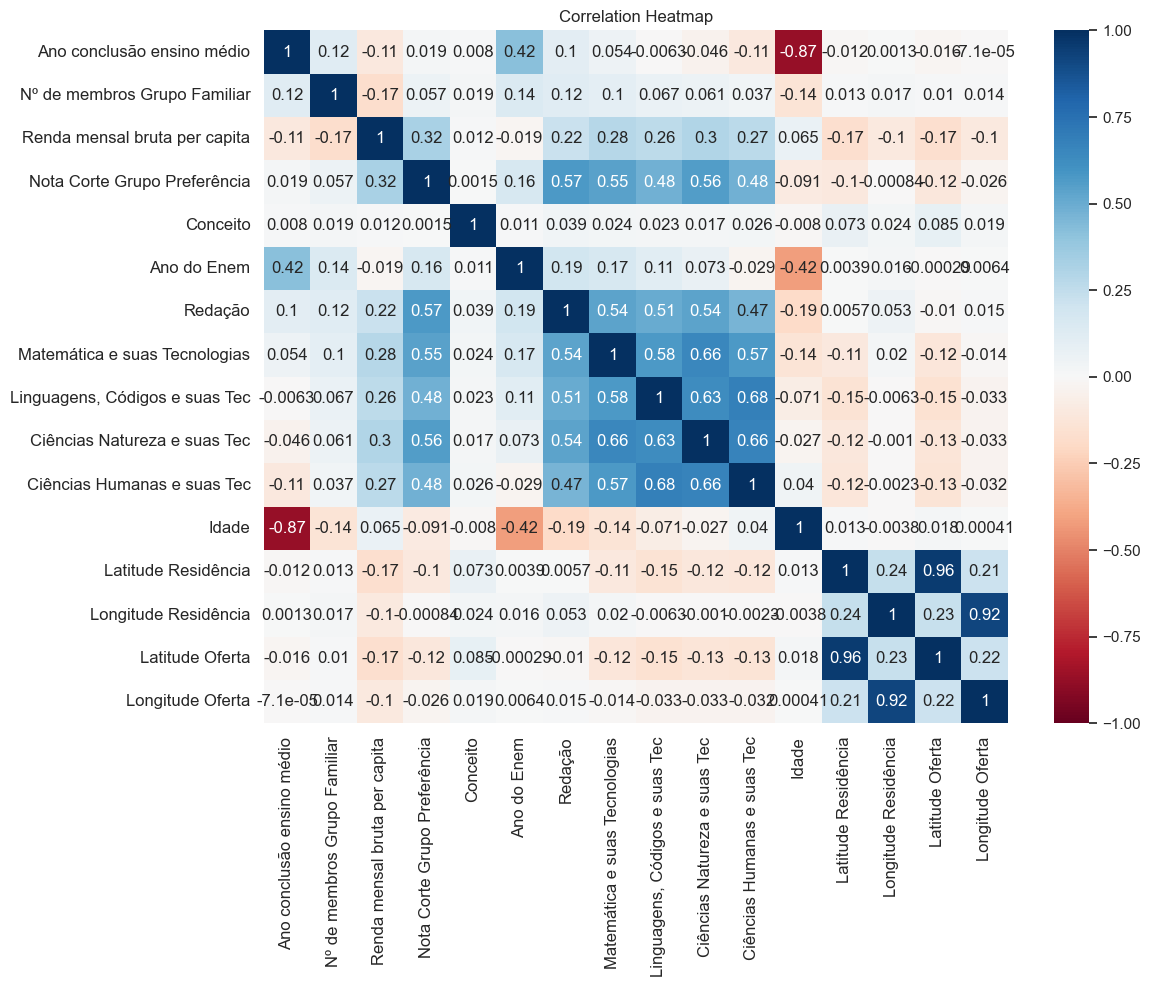

In [79]:
#Visualiza a correlação dos atributos via mapa de calor
sns.set()
plt.figure(figsize = (12, 9))
s = sns.heatmap(df_fies_merged.corr(),
               annot = True, 
               cmap = 'RdBu',
               vmin = -1, 
               vmax = 1)
s.set_yticklabels(s.get_yticklabels(), rotation = 0, fontsize = 12)
s.set_xticklabels(s.get_xticklabels(), rotation = 90, fontsize = 12)
plt.title('Correlation Heatmap')
plt.show()
#Percebe-se uma alta correlação positiva entre latitude e longitude do município de residência do estudante e 
#do município de oferta do curso, o que faz sentido. O candidato busca um curso na própria cidade ou em cidade próxima à sua.
#Percebe-se também uma alta correlação negativa entre a idade do candidato e o ano de conclusão do ensino médio.
#Ou seja, quanto mais velho o candidato, mais provável que tenha terminado o ensino médio mais cedo, o que é esperado.

# Tratamento dos atributos categóricos

Todos os 7 atributos categóricos são atributos categóricos nominais. Será feito primeiro a codificação via label encoder para transformação de dados textuais em numéricos e depois via one hot encoder (apenas para os atributos categóricos não binários).

In [80]:
#Usa amostra de 10 mil linhas aleatórias para o processamento, para evitar demora no processamento de todo o dataframe
df_fies_amostra = df_fies_merged.sample(n=10000, random_state=42)

In [81]:
fies_lab_encoded = df_fies_amostra.iloc[:].values
fies_lab_encoded

array([['F', 'BRANCA', 'NÃO', ..., -38.5423, -3.71664, -38.5423],
       ['F', 'PARDA', 'NÃO', ..., -39.0979, -10.6859, -37.8626],
       ['F', 'BRANCA', 'NÃO', ..., -53.7412, -24.9573, -53.459],
       ...,
       ['M', 'PARDA', 'NÃO', ..., -50.4401, -21.2076, -50.4401],
       ['F', 'PARDA', 'NÃO', ..., -38.5423, -3.71664, -38.5423],
       ['F', 'PARDA', 'NÃO', ..., -42.8034, -5.09194, -42.8034]],
      dtype=object)

In [82]:
#Codificação dos dados categóricos via label encoder
label_encoder_Sexo = LabelEncoder()
label_encoder_Etnia = LabelEncoder()
label_encoder_PCD = LabelEncoder()
label_encoder_TpEscola = LabelEncoder()
label_encoder_CursoSup = LabelEncoder()
label_encoder_Prof = LabelEncoder()
label_encoder_GrupPref = LabelEncoder()
label_encoder_NomeCurso = LabelEncoder()
label_encoder_Turno = LabelEncoder()

fies_lab_encoded[:,0] = label_encoder_Sexo.fit_transform(fies_lab_encoded[:,0])
fies_lab_encoded[:,1] = label_encoder_Etnia.fit_transform(fies_lab_encoded[:,1])
fies_lab_encoded[:,2] = label_encoder_PCD.fit_transform(fies_lab_encoded[:,2])
fies_lab_encoded[:,3] = label_encoder_TpEscola.fit_transform(fies_lab_encoded[:,3])
fies_lab_encoded[:,5] = label_encoder_CursoSup.fit_transform(fies_lab_encoded[:,5])
fies_lab_encoded[:,6] = label_encoder_Prof.fit_transform(fies_lab_encoded[:,6])
fies_lab_encoded[:,10] = label_encoder_NomeCurso.fit_transform(fies_lab_encoded[:,10])
fies_lab_encoded[:,11] = label_encoder_Turno.fit_transform(fies_lab_encoded[:,11])
fies_lab_encoded.shape

(10000, 24)

In [83]:
#Codificação dos dados categóricos não binários (Etnia/Cor, Tipo de escola, Nome do Curso e Turno) via one hot encoder
onehotencoder_fies = ColumnTransformer(transformers=[('OneHot', OneHotEncoder(), [1,3,10,11])], remainder='passthrough')
fies_ohe_encoded = onehotencoder_fies.fit_transform(fies_lab_encoded)
fies_ohe_encoded

<10000x166 sparse matrix of type '<class 'numpy.float64'>'
	with 202918 stored elements in Compressed Sparse Row format>

# Normalização dos dados

In [84]:
# Escalonamento dos valores via padronização
scaler_fies = StandardScaler(with_mean=False)
fies_scaled = scaler_fies.fit_transform(fies_ohe_encoded)
fies_scaled

<10000x166 sparse matrix of type '<class 'numpy.float64'>'
	with 202918 stored elements in Compressed Sparse Row format>

# Clusterização Hierárquica

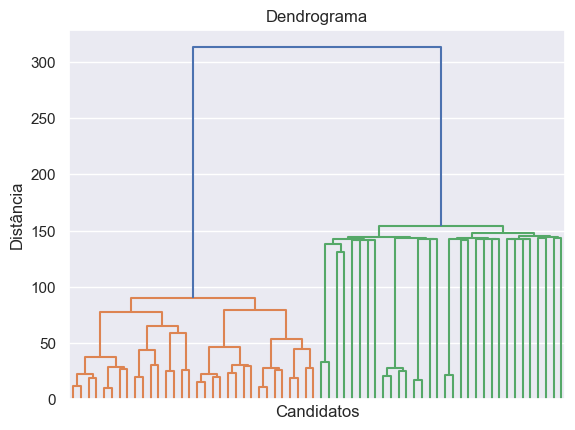

In [85]:
#Aplica o dendograma para encontrar a quantidade ideal de clusters
dendrograma = dendrogram(linkage(fies_scaled.toarray(), method='ward'),
                         truncate_mode = 'level',
                         p = 5,
                         show_leaf_counts = False,
                         no_labels = True)
plt.title('Dendrograma')
plt.xlabel('Candidatos')
plt.ylabel('Distância');
#No agrupamento hierárquico a quantidade ideal de clusters é dada pela maior linha vertical no dendograma que não é cortada
#por nenhuma linha horizontal do diagrama. Neste caso a quantidade de clusters é 2

In [86]:
#Aplica o algoritmo de agrupamento hierárquico com 2 clusters
hc_fies = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage = 'ward')
hc_rotulos = hc_fies.fit_predict(fies_scaled.toarray())
np.unique(hc_rotulos, return_counts=True)

(array([0, 1], dtype=int64), array([7579, 2421], dtype=int64))

In [87]:
#Cria dataframe com cópia dos dados analisados, anexando coluna com a classificação pelo agrupamento hierárquico
df_fies_clust = df_fies_amostra.copy()
df_fies_clust['Cluster HC'] = hc_rotulos

## Análise de resultado do HC

Percebe-se as seguintes diferenças entre os grupos comparando o grupo 1 com o grupo 0:
-	Em tamanho possui aproximadamente 1/3 dos candidatos do grupo 0
-	O número de membros do grupo familiar é maior e superior a 2
-	É mais jovem 1,5 anos
-	A renda per capita é ~50% maior
-	Almeja curso com nota de corte ~30% maior 
-	Possui notas mais altas em todas as disciplinas do ENEM
-	Candidata-se com mais frequência a cursos ofertados mais longe de sua residência (~120 km em média)
- 	Está na região sudeste, enquanto o do grupo 0 na região nordeste
-	Não cursou o ensino médio no ensino público
-	Opta por curso de turno integral, enquanto no grupo 0 a opção é turno noturno
-	Opta pelo curso de medicina, enquanto o grupo 0 pelo de direito
- 	É de cor branca, enquanto o do grupo 0 é de cor parda

Como característica em comum, os candidatos em ambos os grupos são do sexo feminino, concluíram o ensino médio no mesmo ano, optam por curso com o mesmo conceito no MEC.

In [88]:
df_fies_clust[df_fies_clust['Cluster HC'] == 0].describe()

Ano conclusão ensino médio  Nº de membros Grupo Familiar  \
count                 7579.000000                   7579.000000   
mean                  2014.582927                      1.807231   
std                      5.569905                      1.252149   
min                   1974.000000                      0.000000   
25%                   2013.000000                      1.000000   
50%                   2017.000000                      2.000000   
75%                   2018.000000                      3.000000   
max                   2020.000000                     10.000000   

       Renda mensal bruta per capita  Nota Corte Grupo Preferência  \
count                    7579.000000                   7579.000000   
mean                      964.477203                    574.846558   
std                       578.096211                     58.723103   
min                       104.500000                    450.080000   
25%                       523.750000                    540.120000   
50%                       833.330000                    575.100000   
75%                      1212.500000                    606.580000   
max                      4056.670000                    775.040000   

          Conceito  Ano do Enem      Redação  Matemática e suas Tecnologias  \
count  7579.000000  7579.000000  7579.000000                    7579.000000   
mean      3.556274  2017.505740   611.406518                     511.664692   
std       1.178273     2.334309   128.138758                      87.475035   
min       0.000000  2010.000000   240.000000                     318.800000   
25%       3.000000  2016.000000   540.000000                     445.450000   
50%       4.000000  2018.000000   600.000000                     502.300000   
75%       4.000000  2019.000000   680.000000                     568.900000   
max       5.000000  2020.000000   980.000000                     914.400000   

       Linguagens, Códigos e suas Tec  Ciências Natureza e suas Tec  \
count                     7579.000000                   7579.000000   
mean                       525.175261                    485.713366   
std                         50.866967                     63.227269   
min                        316.600000                    334.200000   
25%                        494.000000                    437.800000   
50%                        527.400000                    482.600000   
75%                        558.900000                    528.600000   
max                        721.000000                    712.600000   

       Ciências Humanas e suas Tec        Idade  Latitude Residência  \
count                  7579.000000  7579.000000          7579.000000   
mean                    535.668795    23.774640           -14.108480   
std                      67.846851     7.004401             8.368029   
min                     322.600000    16.000000           -33.686600   
25%                     489.900000    19.000000           -22.301600   
50%                     538.700000    21.000000           -14.223100   
75%                     584.000000    26.000000            -6.699570   
max                     759.500000    70.000000             2.823840   

       Longitude Residência  Latitude Oferta  Longitude Oferta  Cluster HC  
count           7579.000000      7579.000000       7579.000000      7579.0  
mean             -45.009385       -14.189508        -44.960546         0.0  
std                6.419627         8.379815          6.441783         0.0  
min              -72.675600       -32.034900        -67.824300         0.0  
25%              -48.489800       -22.376800        -48.489800         0.0  
50%              -44.282500       -14.861500        -44.282500         0.0  
75%              -39.514700        -6.880040        -39.307600         0.0  
max              -34.828400         2.823840        -34.828400         0.0

In [89]:
df_fies_clust[df_fies_clust['Cluster HC'] == 1].describe()

Ano conclusão ensino médio  Nº de membros Grupo Familiar  \
count                 2421.000000                   2421.000000   
mean                  2014.821148                      2.050392   
std                      4.788138                      1.253730   
min                   1979.000000                      0.000000   
25%                   2014.000000                      1.000000   
50%                   2016.000000                      2.000000   
75%                   2018.000000                      3.000000   
max                   2020.000000                      9.000000   

       Renda mensal bruta per capita  Nota Corte Grupo Preferência  \
count                    2421.000000                   2421.000000   
mean                     1455.869674                    742.013028   
std                       782.103648                     17.807075   
min                       209.000000                    682.940000   
25%                       850.000000                    728.540000   
50%                      1227.670000                    739.720000   
75%                      2000.000000                    757.060000   
max                      3903.090000                    775.040000   

          Conceito  Ano do Enem      Redação  Matemática e suas Tecnologias  \
count  2421.000000  2421.000000  2421.000000                    2421.000000   
mean      3.596448  2018.343660   819.869888                     656.452953   
std       1.569430     2.034219   127.984913                     101.294323   
min       0.000000  2010.000000   300.000000                     356.600000   
25%       4.000000  2018.000000   740.000000                     593.100000   
50%       4.000000  2019.000000   860.000000                     672.800000   
75%       4.000000  2020.000000   920.000000                     728.800000   
max       5.000000  2020.000000  1000.000000                     929.600000   

       Linguagens, Códigos e suas Tec  Ciências Natureza e suas Tec  \
count                     2421.000000                   2421.000000   
mean                       588.941760                    591.714292   
std                         48.208698                     67.550555   
min                        342.200000                    357.400000   
25%                        560.500000                    554.200000   
50%                        592.900000                    600.100000   
75%                        621.700000                    638.700000   
max                        751.200000                    790.000000   

       Ciências Humanas e suas Tec        Idade  Latitude Residência  \
count                  2421.000000  2421.000000          2421.000000   
mean                    621.426353    22.323833           -16.148242   
std                      60.811127     5.199655             7.268466   
min                     369.800000    16.000000           -32.015100   
25%                     586.900000    19.000000           -22.223100   
50%                     629.000000    21.000000           -17.859500   
75%                     664.800000    24.000000            -9.388660   
max                     824.900000    61.000000             2.823840   

       Longitude Residência  Latitude Oferta  Longitude Oferta  Cluster HC  
count           2421.000000      2421.000000       2421.000000      2421.0  
mean             -45.463596       -16.442690        -46.023919         1.0  
std                5.888447         7.019122          6.484368         0.0  
min              -72.675600       -29.162900        -67.824300         1.0  
25%              -48.977000       -22.120700        -49.264600         1.0  
50%              -45.358400       -18.854500        -45.947700         1.0  
75%              -41.743200       -10.240000        -41.879900         1.0  
max              -34.815100        -1.455400        -34.877100         1.0

In [90]:
df_fies_clust[df_fies_clust['Cluster HC'] == 0].describe(include=[object])

Sexo Etnia/Cor Pessoa com deficiência? Tipo de escola no ensino médio  \
count   7579      7579                    7579                           7579   
unique     2         5                       2                              3   
top        F     PARDA                     NÃO                            SIM   
freq    4987      3766                    7492                           5985   

       Concluiu curso superior? Professor rede pública ensino? Nome do curso  \
count                      7579                           7579          7579   
unique                        2                              2           134   
top                         NÃO                            NÃO       DIREITO   
freq                       6782                           6977          1296   

          Turno  
count      7579  
unique        4  
top     NOTURNO  
freq       4615

In [91]:
df_fies_clust[df_fies_clust['Cluster HC'] == 1].describe(include=[object])

Sexo Etnia/Cor Pessoa com deficiência? Tipo de escola no ensino médio  \
count   2421      2421                    2421                           2421   
unique     2         3                       1                              2   
top        F    BRANCA                     NÃO                            NÃO   
freq    1691      1415                    2421                           1388   

       Concluiu curso superior? Professor rede pública ensino? Nome do curso  \
count                      2421                           2421          2421   
unique                        2                              2             1   
top                         NÃO                            NÃO      MEDICINA   
freq                       2040                           2420          2421   

           Turno  
count       2421  
unique         1  
top     INTEGRAL  
freq        2421

# Clusterização pelo algoritmo K-Means

2023-04-09 17:28:03.095203
2023-04-09 17:28:04.713886
2023-04-09 17:28:08.084873
2023-04-09 17:28:16.293924
2023-04-09 17:28:30.800139
2023-04-09 17:28:44.281094
2023-04-09 17:28:57.181602
2023-04-09 17:29:12.423847
2023-04-09 17:29:28.466970
2023-04-09 17:29:49.494731


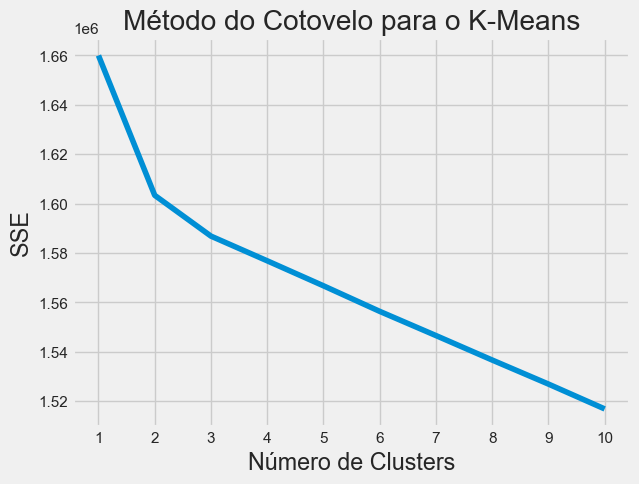

In [92]:
#Escolha do número de clusters pelo método do Cotovelo. O valor ideal é dado pelo ponto de inflexão mais acentuado.
sse = []
k_range = range(1, 11)
for k in k_range:
    print(dt.now())
    kmeans = KMeans(n_clusters=k, init = 'k-means++', random_state = 0)
    kmeans.fit(fies_scaled)
    sse.append(kmeans.inertia_)  
plt.style.use("fivethirtyeight")
plt.plot(k_range, sse)
plt.xticks(k_range)
plt.xlabel("Número de Clusters")
plt.ylabel("SSE")
plt.title('Método do Cotovelo para o K-Means')
plt.show()

In [93]:
#Embora o método do cotovelo e o da silhueta sejam técnicas subjetivas, em ambos observou-se a quantidade ideal de clusters 2
#Aplica o algoritmo KMeans com 2 clusters
kmeans = KMeans(n_clusters=2, init = 'k-means++', random_state = 0)
kmeans_rotulos = kmeans.fit_predict(fies_scaled)
np.unique(kmeans_rotulos, return_counts=True)

(array([0, 1]), array([2929, 7071], dtype=int64))

In [94]:
#Anexa coluna com a classificação pelo agrupamento K-means
df_fies_clust['Cluster K-means'] = kmeans_rotulos

## Análise de resultado do K-means

Percebe-se as seguintes diferenças entre os grupos comparando o grupo 0 com o grupo 1:
- Em tamanho pouco mais da metade dos candidatos do grupo 1
- O número de membros do grupo familiar é ligeiramente maior, superior a 2
- É mais jovem quase 2 anos
- A renda per capita é ~50% maior
- Almejam curso com nota de corte ~30% maior
- Possuem notas mais altas em todas as disciplinas do ENEM, em média 20% maior
- Candidata-se com mais frequência a cursos ofertados mais longe de sua residência
- Não cursou o ensino médio no ensino público
- Opta por curso de turno integral, enquanto no grupo 1 a opção é turno noturno
- Opta pelo curso de medicina, enquanto o grupo 1 pelo de direito
-	É de cor branca, enquanto do grupo 1 é de cor parda

Como característica em comum, os candidatos em ambos grupos são do sexo feminino, concluíram o ensino médio no mesmo ano e concentram-se no meio da região sudeste.

In [95]:
df_fies_clust[df_fies_clust['Cluster K-means'] == 0].describe()

Ano conclusão ensino médio  Nº de membros Grupo Familiar  \
count                 2929.000000                   2929.000000   
mean                  2014.859679                      2.038238   
std                      4.894143                      1.249551   
min                   1979.000000                      0.000000   
25%                   2014.000000                      1.000000   
50%                   2016.000000                      2.000000   
75%                   2018.000000                      3.000000   
max                   2020.000000                      9.000000   

       Renda mensal bruta per capita  Nota Corte Grupo Preferência  \
count                    2929.000000                   2929.000000   
mean                     1458.934783                    728.858860   
std                       782.029692                     46.975977   
min                       145.280000                    452.260000   
25%                       848.330000                    725.220000   
50%                      1240.000000                    736.660000   
75%                      2000.000000                    756.580000   
max                      3903.090000                    775.040000   

          Conceito  Ano do Enem      Redação  Matemática e suas Tecnologias  \
count  2929.000000  2929.000000  2929.000000                    2929.000000   
mean      3.588255  2018.346535   817.791055                     655.517378   
std       1.543477     2.005735   124.180178                      97.782525   
min       0.000000  2010.000000   340.000000                     356.600000   
25%       4.000000  2018.000000   740.000000                     592.400000   
50%       4.000000  2019.000000   860.000000                     669.200000   
75%       4.000000  2020.000000   920.000000                     726.600000   
max       5.000000  2020.000000  1000.000000                     929.600000   

       Linguagens, Códigos e suas Tec  Ciências Natureza e suas Tec  \
count                     2929.000000                   2929.000000   
mean                       590.078935                    591.660225   
std                         45.398425                     63.993629   
min                        346.700000                    351.900000   
25%                        562.700000                    554.400000   
50%                        592.900000                    598.200000   
75%                        621.200000                    635.900000   
max                        751.200000                    790.000000   

       Ciências Humanas e suas Tec        Idade  Latitude Residência  \
count                  2929.000000  2929.000000          2929.000000   
mean                    622.184978    22.274838           -16.182647   
std                      58.695473     5.300459             7.326615   
min                     339.100000    16.000000           -32.015100   
25%                     589.300000    19.000000           -22.313600   
50%                     628.600000    21.000000           -17.859500   
75%                     663.600000    24.000000            -9.388660   
max                     824.900000    61.000000             2.823840   

       Longitude Residência  Latitude Oferta  Longitude Oferta   Cluster HC  \
count           2929.000000      2929.000000       2929.000000  2929.000000   
mean             -45.552971       -16.473374        -46.041352     0.810857   
std                5.918146         7.118272          6.418277     0.391689   
min              -72.675600       -29.912800        -67.824300     0.000000   
25%              -49.087100       -22.293600        -49.264600     1.000000   
50%              -45.559300       -18.854500        -45.947700     1.000000   
75%              -41.788300       -10.240000        -41.955500     1.000000   
max              -34.815100         2.823840        -34.828400     1.000000   

       Cluster K-means  
count           2929.0  
mean     

In [96]:
df_fies_clust[df_fies_clust['Cluster K-means'] == 1].describe()

Ano conclusão ensino médio  Nº de membros Grupo Familiar  \
count                 7071.000000                   7071.000000   
mean                  2014.549852                      1.794796   
std                      5.582760                      1.252960   
min                   1974.000000                      0.000000   
25%                   2013.000000                      1.000000   
50%                   2017.000000                      2.000000   
75%                   2018.000000                      3.000000   
max                   2020.000000                     10.000000   

       Renda mensal bruta per capita  Nota Corte Grupo Preferência  \
count                    7071.000000                   7071.000000   
mean                      927.904571                    568.285674   
std                       542.554080                     50.893471   
min                       104.500000                    450.080000   
25%                       522.500000                    537.740000   
50%                       800.000000                    571.540000   
75%                      1197.750000                    600.680000   
max                      4056.670000                    769.320000   

          Conceito  Ano do Enem      Redação  Matemática e suas Tecnologias  \
count  7071.000000   7071.00000  7071.000000                    7071.000000   
mean      3.556781   2017.44435   597.291048                     501.650247   
std       1.159607      2.35258   117.708143                      79.115434   
min       0.000000   2010.00000   240.000000                     318.800000   
25%       3.000000   2016.00000   520.000000                     441.900000   
50%       4.000000   2018.00000   580.000000                     494.500000   
75%       4.000000   2019.00000   660.000000                     556.550000   
max       5.000000   2020.00000   980.000000                     797.200000   

       Linguagens, Códigos e suas Tec  Ciências Natureza e suas Tec  \
count                     7071.000000                   7071.000000   
mean                       520.123052                    478.120365   
std                         48.342578                     57.363491   
min                        316.600000                    334.200000   
25%                        490.950000                    434.500000   
50%                        523.300000                    476.800000   
75%                        552.700000                    519.000000   
max                        708.600000                    672.200000   

       Ciências Humanas e suas Tec        Idade  Latitude Residência  \
count                  7071.000000  7071.000000          7071.000000   
mean                    529.193495    23.899166           -13.947687   
std                      64.408351     7.069598             8.397879   
min                     322.600000    16.000000           -33.686600   
25%                     486.350000    19.000000           -22.227600   
50%                     533.200000    21.000000           -13.250600   
75%                     575.350000    26.000000            -6.403010   
max                     732.300000    70.000000             2.823840   

       Longitude Residência  Latitude Oferta  Longitude Oferta   Cluster HC  \
count           7071.000000      7071.000000       7071.000000  7071.000000   
mean             -44.939732       -14.014924        -44.876929     0.006505   
std                6.440460         8.407936          6.458053     0.080399   
min              -72.675600       -32.034900        -67.824300     0.000000   
25%              -48.489800       -22.293200        -48.489800     0.000000   
50%              -44.282500       -13.850900        -44.252600     0.000000   
75%              -39.396050        -6.396270        -39.307600     0.000000   
max              -34.828400         2.823840        -34.828400     1.000000   

       Cluster K-means  
count           7071.0  
mean     

In [97]:
df_fies_clust[df_fies_clust['Cluster K-means'] == 0].describe(include=[object])

Sexo Etnia/Cor Pessoa com deficiência? Tipo de escola no ensino médio  \
count   2929      2929                    2929                           2929   
unique     2         5                       2                              3   
top        F    BRANCA                     NÃO                            NÃO   
freq    2041      1714                    2892                           1648   

       Concluiu curso superior? Professor rede pública ensino? Nome do curso  \
count                      2929                           2929          2929   
unique                        2                              2            33   
top                         NÃO                            NÃO      MEDICINA   
freq                       2449                           2882          2663   

           Turno  
count       2929  
unique         4  
top     INTEGRAL  
freq        2770

In [98]:
df_fies_clust[df_fies_clust['Cluster K-means'] == 1].describe(include=[object])

Sexo Etnia/Cor Pessoa com deficiência? Tipo de escola no ensino médio  \
count   7071      7071                    7071                           7071   
unique     2         5                       2                              3   
top        F     PARDA                     NÃO                            SIM   
freq    4637      3640                    7021                           5930   

       Concluiu curso superior? Professor rede pública ensino? Nome do curso  \
count                      7071                           7071          7071   
unique                        2                              2           132   
top                         NÃO                            NÃO       DIREITO   
freq                       6373                           6515          1258   

          Turno  
count      7071  
unique        4  
top     NOTURNO  
freq       4559

# Clusterização pelo algoritmo PAM (K-medoids)

2023-04-09 17:30:18.163378
2023-04-09 17:30:30.643218
2023-04-09 17:30:41.706294
2023-04-09 17:30:50.404081
2023-04-09 17:30:58.993481
2023-04-09 17:31:08.489181
2023-04-09 17:31:18.650980
2023-04-09 17:31:29.220742
2023-04-09 17:31:39.689874
2023-04-09 17:31:50.526972


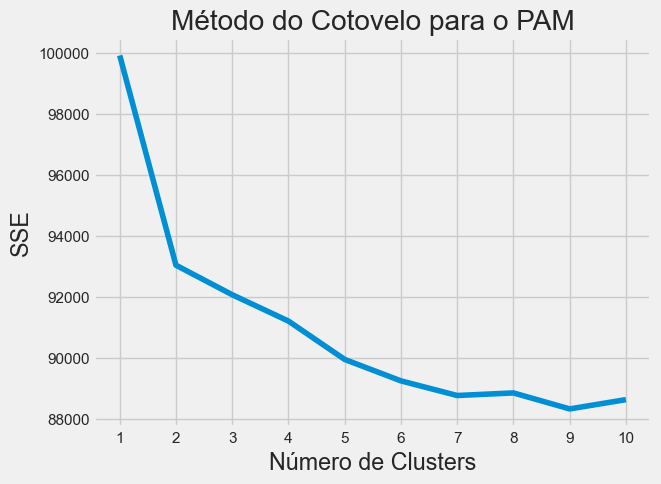

In [99]:
#Escolha do número de clusters pelo método do Cotovelo. O valor ideal é dado pelo ponto de inflexão mais acentuado.
sse = []
k_range = range(1, 11)
for k in k_range:
    print(dt.now())
    pam = KMedoids(n_clusters=k)
    pam.fit(fies_scaled)
    sse.append(pam.inertia_)  
plt.style.use("fivethirtyeight")
plt.plot(k_range, sse)
plt.xticks(k_range)
plt.xlabel("Número de Clusters")
plt.ylabel("SSE")
plt.title('Método do Cotovelo para o PAM')
plt.show()

In [100]:
#Aplica o algoritmo PAM com 2 clusters
pam = KMedoids(n_clusters=2).fit(fies_scaled)
np.unique(pam.labels_, return_counts=True)

(array([0, 1], dtype=int64), array([6600, 3400], dtype=int64))

In [101]:
#Anexa coluna com a classificação pelo agrupamento PAM
df_fies_clust['Cluster PAM'] = pam.labels_

## Análise de resultado do PAM

Identificam-se as seguintes diferenças do grupo 1 para o grupo 0:
-	Em tamanho possui aproximadamente 1/2 dos candidatos do grupo 0
-	O número de membros do grupo familiar é maior e superior a 2
-	É mais jovem ~1,5 anos
-	A renda per capita é quase 60% maior
-	Almeja curso com nota de corte ~25% maior 
-	Possui notas mais altas em todas as disciplinas do ENEM
-	Candidata-se com mais frequência a cursos ofertados mais longe de sua residência (~80 km em média)
-	Está na região sudeste, enquanto o do grupo 0 na região nordeste
-	Não cursou o ensino médio no ensino público
-	Opta por curso de turno integral, enquanto no grupo 0 a opção é turno noturno
-	Opta pelo curso de medicina, enquanto o grupo 0 pelo de direito
-	É de cor branca, enquanto o do grupo 0 é de cor parda

Como característica em comum, os candidatos em ambos os grupos são do sexo feminino, concluíram o ensino médio no mesmo ano, optam por curso com o mesmo conceito no MEC.

In [102]:
df_fies_clust[df_fies_clust['Cluster PAM'] == 0].describe()

Ano conclusão ensino médio  Nº de membros Grupo Familiar  \
count                 6600.000000                   6600.000000   
mean                  2014.535455                      1.777727   
std                      5.574302                      1.249272   
min                   1974.000000                      0.000000   
25%                   2013.000000                      1.000000   
50%                   2017.000000                      2.000000   
75%                   2018.000000                      3.000000   
max                   2020.000000                     10.000000   

       Renda mensal bruta per capita  Nota Corte Grupo Preferência  \
count                    6600.000000                   6600.000000   
mean                      904.536341                    568.452182   
std                       518.208095                     51.911202   
min                       104.500000                    450.080000   
25%                       522.500000                    537.250000   
50%                       780.875000                    571.510000   
75%                      1150.000000                    600.740000   
max                      3135.000000                    769.320000   

          Conceito  Ano do Enem      Redação  Matemática e suas Tecnologias  \
count  6600.000000  6600.000000  6600.000000                    6600.000000   
mean      3.566212  2017.471667   594.778788                     498.389197   
std       1.152099     2.331216   117.743795                      77.782188   
min       0.000000  2010.000000   240.000000                     318.800000   
25%       3.000000  2016.000000   520.000000                     440.175000   
50%       4.000000  2018.000000   580.000000                     491.300000   
75%       4.000000  2019.000000   660.000000                     551.600000   
max       5.000000  2020.000000   980.000000                     797.200000   

       Linguagens, Códigos e suas Tec  Ciências Natureza e suas Tec  \
count                     6600.000000                   6600.000000   
mean                       518.092742                    475.302015   
std                         47.727774                     56.523936   
min                        316.600000                    334.200000   
25%                        489.300000                    432.175000   
50%                        521.400000                    473.850000   
75%                        550.050000                    515.500000   
max                        708.600000                    683.700000   

       Ciências Humanas e suas Tec        Idade  Latitude Residência  \
count                  6600.000000  6600.000000          6600.000000   
mean                    526.285818    23.960909           -13.458328   
std                      63.809448     7.090264             8.255216   
min                     322.600000    16.000000           -33.686600   
25%                     483.900000    19.000000           -21.291000   
50%                     529.700000    21.000000           -12.897800   
75%                     572.000000    26.000000            -5.984983   
max                     732.300000    70.000000             2.823840   

       Longitude Residência  Latitude Oferta  Longitude Oferta   Cluster HC  \
count           6600.000000      6600.000000       6600.000000  6600.000000   
mean             -44.752419       -13.527190        -44.693818     0.009848   
std                6.472235         8.268759          6.501977     0.098757   
min              -72.675600       -32.034900        -67.824300     0.000000   
25%              -48.374300       -21.248000        -48.489800     0.000000   
50%              -44.069950       -12.971800        -43.926600     0.000000   
75%              -39.300125        -5.793570        -39.015500     0.000000   
max              -34.828400         2.823840        -34.828400     1.000000   

       Cluster K-means  Cluster PAM  
count      6600.00000

In [103]:
df_fies_clust[df_fies_clust['Cluster PAM'] == 1].describe()

Ano conclusão ensino médio  Nº de membros Grupo Familiar  \
count                 3400.000000                   3400.000000   
mean                  2014.844706                      2.037647   
std                      5.013075                      1.253789   
min                   1977.000000                      0.000000   
25%                   2014.000000                      1.000000   
50%                   2016.000000                      2.000000   
75%                   2018.000000                      3.000000   
max                   2020.000000                      9.000000   

       Renda mensal bruta per capita  Nota Corte Grupo Preferência  \
count                    3400.000000                   3400.000000   
mean                     1430.733338                    706.291529   
std                       778.962490                     72.276852   
min                       145.280000                    452.260000   
25%                       816.775000                    712.860000   
50%                      1211.325000                    731.260000   
75%                      2000.000000                    754.860000   
max                      4056.670000                    775.040000   

          Conceito  Ano do Enem      Redação  Matemática e suas Tecnologias  \
count  3400.000000  3400.000000  3400.000000                    3400.000000   
mean      3.565588  2018.168529   792.122059                     640.532529   
std       1.507593     2.145243   138.210641                     102.940490   
min       0.000000  2010.000000   280.000000                     356.600000   
25%       4.000000  2018.000000   680.000000                     571.375000   
50%       4.000000  2019.000000   820.000000                     652.300000   
75%       4.000000  2020.000000   920.000000                     717.700000   
max       5.000000  2020.000000  1000.000000                     929.600000   

       Linguagens, Códigos e suas Tec  Ciências Natureza e suas Tec  \
count                     3400.000000                   3400.000000   
mean                       584.329176                    581.402529   
std                         47.952219                     67.766483   
min                        341.900000                    337.700000   
25%                        556.700000                    539.200000   
50%                        586.700000                    586.450000   
75%                        617.900000                    629.525000   
max                        751.200000                    790.000000   

       Ciências Humanas e suas Tec        Idade  Latitude Residência  \
count                  3400.000000  3400.000000          3400.000000   
mean                    614.947235    22.380000           -16.822970   
std                      61.409267     5.524213             7.496375   
min                     336.400000    16.000000           -32.034900   
25%                     579.250000    19.000000           -22.829450   
50%                     621.500000    21.000000           -19.296050   
75%                     658.500000    24.000000            -9.754870   
max                     824.900000    64.000000             2.823840   

       Longitude Residência  Latitude Oferta  Longitude Oferta   Cluster HC  \
count           3400.000000      3400.000000       3400.000000  3400.000000   
mean             -45.831627       -17.079583        -46.235497     0.692941   
std                5.880697         7.300825          6.278304     0.461342   
min              -72.675600       -32.034900        -67.824300     0.000000   
25%              -49.264300       -22.785800        -49.264600     0.000000   
50%              -46.311200       -19.910200        -46.639500     1.000000   
75%              -42.097475       -10.702700        -42.369300     1.000000   
max              -34.815100         2.823840        -34.828400     1.000000   

       Cluster K-means  Cluster PAM  
count      3400.00000

In [104]:
df_fies_clust[df_fies_clust['Cluster PAM'] == 0].describe(include=[object])

Sexo Etnia/Cor Pessoa com deficiência? Tipo de escola no ensino médio  \
count   6600      6600                    6600                           6600   
unique     2         5                       2                              3   
top        F     PARDA                     NÃO                            SIM   
freq    4320      3633                    6553                           5789   

       Concluiu curso superior? Professor rede pública ensino? Nome do curso  \
count                      6600                           6600          6600   
unique                        2                              2           129   
top                         NÃO                            NÃO       DIREITO   
freq                       5959                           6066          1260   

          Turno  
count      6600  
unique        4  
top     NOTURNO  
freq       4355

In [105]:
df_fies_clust[df_fies_clust['Cluster PAM'] == 1].describe(include=[object])

Sexo Etnia/Cor Pessoa com deficiência? Tipo de escola no ensino médio  \
count   3400      3400                    3400                           3400   
unique     2         5                       2                              3   
top        F    BRANCA                     NÃO                            NÃO   
freq    2358      2147                    3360                           1931   

       Concluiu curso superior? Professor rede pública ensino? Nome do curso  \
count                      3400                           3400          3400   
unique                        2                              2            61   
top                         NÃO                            NÃO      MEDICINA   
freq                       2863                           3331          2647   

           Turno  
count       3400  
unique         4  
top     INTEGRAL  
freq        2822

# Clusterização pelo algoritmo DBScan

Os parâmetros principais para o algoritmo são:

eps: define a distância máxima entre dois pontos para que eles possam ser considerados parte do mesmo cluster. Um valor muito pequeno pode resultar em muitos clusters e um valor muito grande pode resultar em todos os pontos serem agrupados em um único cluster. 

min_samples: define o número mínimo de pontos necessários para formar um cluster. Um valor muito baixo pode resultar em ruído sendo considerado como um cluster e um valor muito alto pode resultar em clusters muito pequenos. 

Uma maneira de ajustar esses parâmetros é traçar um gráfico da distância média para os k vizinhos mais próximos (k-distance plot) e encontrar o valor de eps onde há um ponto de inflexão na curva da distância.

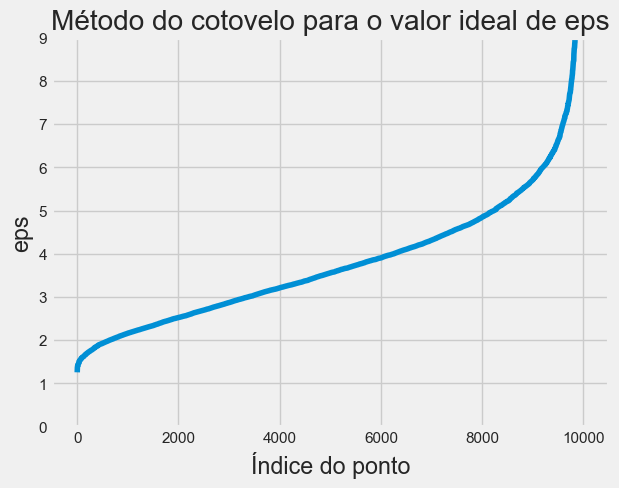

In [106]:
#Usa o método do cotovelo para encontrar o valor ideal de eps, no ponto onda há uma inflexão na curva.
k = 4 
nbrs = NearestNeighbors(n_neighbors=k+1).fit(fies_scaled)
distances, indices = nbrs.kneighbors(fies_scaled)
k_dist = distances[:, -1]

# Ordene as distâncias em ordem crescente
sorted_distances = np.sort(k_dist)

plt.plot(np.arange(len(sorted_distances)), sorted_distances)
plt.ylim(0,9)
plt.xlabel('Índice do ponto')
plt.ylabel('eps')
plt.title('Método do cotovelo para o valor ideal de eps')
plt.show()

Uma forma de encontrar os valores ideais para os parâmetros do DBSCAN é utilizando a técnica de busca em grade (grid search). Nessa técnica, uma grade de valores é definida para cada parâmetro a ser ajustado e o algoritmo é executado em cada combinação possível de valores dos parâmetros, sendo avaliado através de uma métrica de desempenho pré-definida, neste caso o score da silhueta.

In [108]:
# Definindo a grade de valores para os parâmetros
param_grid = {'eps': np.arange(5, 8, 0.2), 'min_samples': np.arange(2, 10, 1)}

# Criando um modelo DBSCAN sem parâmetros definidos
dbscan = DBSCAN()

# Realizando a busca em grade
best_score_silhouette = -1
best_eps_silhouette = 0
best_min_samples_silhouette = 0
for eps in param_grid['eps']:
    for min_samples in param_grid['min_samples']:
        dbscan.set_params(eps=eps, min_samples=min_samples)
        dbscan.fit(fies_scaled)
        if len(set(dbscan.labels_)) > 1:
            score_silhouette= silhouette_score(fies_scaled, dbscan.labels_)
            if score_silhouette > best_score_silhouette:
                best_score_silhouette = score_silhouette
                best_eps_silhouette = eps
                best_min_samples_silhouette = min_samples
        print('eps:', eps, 'min_samples:', min_samples, 'ruído:', np.unique(dbscan.labels_, return_counts=True)[1][0],
              'score_silhouette:', score_silhouette)


# Imprimindo os melhores valores para os parâmetros
print("Melhor valor para eps: ", best_eps_silhouette)
print("Melhor valor para min_samples: ", best_min_samples_silhouette)


eps: 5.0 min_samples: 2 ruído: 801 score_silhouette: 0.039457274902824434
eps: 5.0 min_samples: 3 ruído: 945 score_silhouette: 0.06692567330653318
eps: 5.0 min_samples: 4 ruído: 1090 score_silhouette: 0.089025195780939
eps: 5.0 min_samples: 5 ruído: 1173 score_silhouette: 0.0897885814073615
eps: 5.0 min_samples: 6 ruído: 1273 score_silhouette: 0.08869340487223039
eps: 5.0 min_samples: 7 ruído: 1328 score_silhouette: 0.07951116429713127
eps: 5.0 min_samples: 8 ruído: 1399 score_silhouette: 0.07981790977586667
eps: 5.0 min_samples: 9 ruído: 1488 score_silhouette: 0.07657810232392076
eps: 5.2 min_samples: 2 ruído: 637 score_silhouette: 0.09011642697980136
eps: 5.2 min_samples: 3 ruído: 743 score_silhouette: 0.1188595979091413
eps: 5.2 min_samples: 4 ruído: 892 score_silhouette: 0.12967455855490229
eps: 5.2 min_samples: 5 ruído: 975 score_silhouette: 0.13418810541838355
eps: 5.2 min_samples: 6 ruído: 1058 score_silhouette: 0.130363568317353
eps: 5.2 min_samples: 7 ruído: 1115 score_silhoue

In [109]:
dbscan = DBSCAN(eps = best_eps_silhouette, min_samples=best_min_samples_silhouette)
dbscan.fit(fies_scaled)
np.unique(dbscan.labels_, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
        33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
        50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
        67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83,
        84, 85], dtype=int64),
 array([  95,   69,  119, 7925,   67,  140,    6,    5,   27,   16,  116,
          80,   45,   38,  171,   66,    5,  173,   37,   33,    8,   64,
          57,   63,    2,   32,    5,   12,    7,   34,   11,    4,    7,
          19,   31,   28,   24,    9,    2,    2,    7,    4,   15,   18,
          16,    8,   65,    7,   31,    4,    9,    5,   17,    2,    3,
           3,    8,   13,   20,    5,   11,    3,    2,    2,    6,    3,
           3,    3,    4,    6,    4,    4,    2,    2,    2,    2,    2,
           2,    2,    3,    2,    4,    2,    3,    2,    3,    2],
  

In [110]:
#Anexa coluna com a classificação pelo agrupamento DBScan
df_fies_clust['Cluster DBScan'] = dbscan.labels_

## Análise de resultado do DBScan

O algoritmo criou 86 clusters, deixando 95 candidatos classificados como ruído. Muitos cluster com poucos candidatos (menos de 10), o que não tem muita utilidade. E um único cluster concentrou a maioria dos candidatos, cujo perfil não é muito diferente do perfil médio da amostra, com exceção da opção de curso do curso que é engenharia elétrica, enquanto na amostra é medicina.

In [113]:
df_fies_clust[df_fies_clust['Cluster DBScan'] == 2].describe()

Ano conclusão ensino médio  Nº de membros Grupo Familiar  \
count                 7925.000000                   7925.000000   
mean                  2014.750410                      1.897287   
std                      5.257363                      1.262814   
min                   1974.000000                      0.000000   
25%                   2013.000000                      1.000000   
50%                   2017.000000                      2.000000   
75%                   2018.000000                      3.000000   
max                   2020.000000                     10.000000   

       Renda mensal bruta per capita  Nota Corte Grupo Preferência  \
count                    7925.000000                   7925.000000   
mean                     1115.106260                    633.224522   
std                       687.303316                     86.158521   
min                       104.500000                    450.380000   
25%                       600.000000                    565.300000   
50%                      1000.000000                    609.280000   
75%                      1420.000000                    728.540000   
max                      4056.670000                    775.040000   

          Conceito  Ano do Enem      Redação  Matemática e suas Tecnologias  \
count  7925.000000  7925.000000  7925.000000                    7925.000000   
mean      3.598991  2017.807445   680.938549                     555.164000   
std       1.275007     2.253444   159.562380                     113.798811   
min       0.000000  2010.000000   240.000000                     320.900000   
25%       3.000000  2017.000000   560.000000                     464.500000   
50%       4.000000  2019.000000   660.000000                     539.300000   
75%       4.000000  2019.000000   820.000000                     638.400000   
max       5.000000  2020.000000  1000.000000                     929.600000   

       Linguagens, Códigos e suas Tec  Ciências Natureza e suas Tec  \
count                     7925.000000                   7925.000000   
mean                       545.239975                    518.566902   
std                         57.924938                     81.211513   
min                        316.600000                    334.200000   
25%                        507.200000                    455.400000   
50%                        546.200000                    512.400000   
75%                        584.900000                    578.700000   
max                        751.200000                    790.000000   

       Ciências Humanas e suas Tec        Idade  Latitude Residência  \
count                  7925.000000  7925.000000          7925.000000   
mean                    562.293931    23.158864           -14.569864   
std                      76.834706     6.380171             8.074446   
min                     322.600000    16.000000           -33.686600   
25%                     508.300000    19.000000           -22.026700   
50%                     565.200000    21.000000           -15.779500   
75%                     619.100000    25.000000            -7.192380   
max                     824.900000    70.000000             2.823840   

       Longitude Residência  Latitude Oferta  Longitude Oferta   Cluster HC  \
count           7925.000000      7925.000000       7925.000000  7925.000000   
mean             -45.077284       -14.720487        -45.200190     0.305489   
std                6.244934         8.024649          6.463315     0.460643   
min              -72.675600       -32.034900        -67.824300     0.000000   
25%              -48.670500       -21.970700        -48.953000     0.000000   
50%              -44.282500       -15.779500        -44.282500     0.000000   
75%              -40.295600        -7.221960        -40.287500     1.000000   
max              -34.815100         2.823840        -34.828400     1.000000   

       Cluster K-means  Cluster PAM  Cluster DBScan  
count

In [114]:
df_fies_clust.describe()

Ano conclusão ensino médio  Nº de membros Grupo Familiar  \
count                10000.000000                  10000.000000   
mean                  2014.640600                      1.866100   
std                      5.391784                      1.256793   
min                   1974.000000                      0.000000   
25%                   2013.000000                      1.000000   
50%                   2017.000000                      2.000000   
75%                   2018.000000                      3.000000   
max                   2020.000000                     10.000000   

       Renda mensal bruta per capita  Nota Corte Grupo Preferência  \
count                   10000.000000                  10000.000000   
mean                     1083.443320                    615.317560   
std                       667.556638                     88.420644   
min                       104.500000                    450.080000   
25%                       575.000000                    552.030000   
50%                       984.215000                    593.720000   
75%                      1374.790000                    719.720000   
max                      4056.670000                    775.040000   

           Conceito   Ano do Enem       Redação  \
count  10000.000000  10000.000000  10000.000000   
mean       3.566000   2017.708600    661.875500   
std        1.283982      2.293472    156.150492   
min        0.000000   2010.000000    240.000000   
25%        3.000000   2017.000000    560.000000   
50%        4.000000   2019.000000    640.000000   
75%        4.000000   2019.000000    780.000000   
max        5.000000   2020.000000   1000.000000   

       Matemática e suas Tecnologias  Linguagens, Códigos e suas Tec  \
count                    10000.00000                    10000.000000   
mean                       546.71793                      540.613130   
std                        110.13368                       57.180533   
min                        318.80000                      316.600000   
25%                        460.27500                      503.700000   
50%                        531.35000                      541.200000   
75%                        622.92500                      579.500000   
max                        929.60000                      751.200000   

       Ciências Natureza e suas Tec  Ciências Humanas e suas Tec  \
count                  10000.000000                 10000.000000   
mean                     511.376190                   556.430700   
std                       78.714894                    75.718046   
min                      334.200000                   322.600000   
25%                      450.675000                   503.400000   
50%                      504.750000                   558.300000   
75%                      565.900000                   610.800000   
max                      790.000000                   824.900000   

              Idade  Latitude Residência  Longitude Residência  \
count  10000.000000         10000.000000           10000.00000   
mean      23.423400           -14.602307             -45.11935   
std        6.641712             8.162059               6.29786   
min       16.000000           -33.686600             -72.67560   
25%       19.000000           -22.287800             -48.63660   
50%       21.000000           -15.779500             -44.28250   
75%       25.000000            -7.115510             -40.28750   
max       70.000000             2.823840             -34.81510   

       Latitude Oferta  Longitude Oferta    Cluster HC  Cluster K-means  \
count     10000.000000      10000.000000  10000.000000     10000.000000   
mean        -14.735004        -45.217989      0.242100         0.707100   
std           8.128635          6.467855      0.428376         0.455116   
min         -32.034900        -67.824300      0.000000         0.000000   
25%         -22.293600        -48.953000      0.000000         0.000000   
50%  

In [115]:
df_fies_clust[df_fies_clust['Cluster DBScan'] == 3].describe(include=[object])

Sexo Etnia/Cor Pessoa com deficiência? Tipo de escola no ensino médio  \
count    67        67                      67                             67   
unique    2         3                       1                              3   
top       M     PARDA                     NÃO                            SIM   
freq     57        37                      67                             58   

       Concluiu curso superior? Professor rede pública ensino?  \
count                        67                             67   
unique                        2                              2   
top                         NÃO                            NÃO   
freq                         63                             66   

              Nome do curso    Turno  
count                    67       67  
unique                    1        3  
top     ENGENHARIA ELÉTRICA  NOTURNO  
freq                     67       58

In [116]:
df_fies_clust.describe(include=[object])

Sexo Etnia/Cor Pessoa com deficiência?  \
count   10000     10000                   10000   
unique      2         5                       2   
top         F     PARDA                     NÃO   
freq     6678      4630                    9913   

       Tipo de escola no ensino médio Concluiu curso superior?  \
count                           10000                    10000   
unique                              3                        2   
top                               SIM                      NÃO   
freq                             7018                     8822   

       Professor rede pública ensino? Nome do curso    Turno  
count                           10000         10000    10000  
unique                              2           134        4  
top                               NÃO      MEDICINA  NOTURNO  
freq                             9397          2718     4615

# Análise de redução de dimensionalidade via PCA

Tentou-se a redução da dimensionalidade dos dados via PCA, porém o gráfico mostra que para um % de variância acima de 80% a redução de dimensões ainda é pequena. Isso pode indicar alta correlação entre as variáveis. O gráfico também não apresenta nenhum ponto de inflexão.

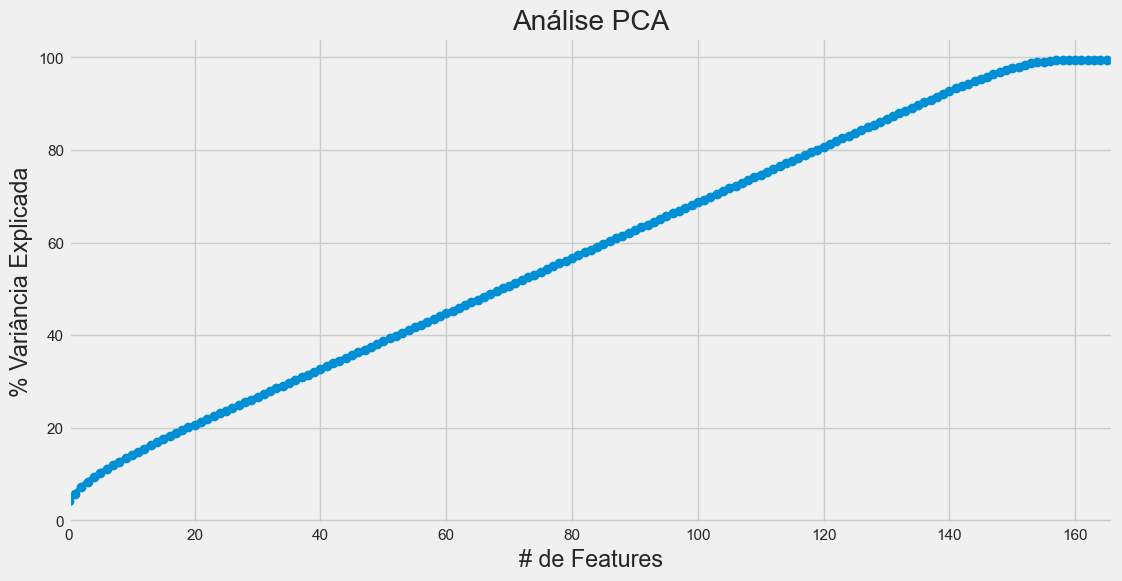

In [117]:
#Avalia a  redução das dimensões utilizando o Principal Component Analysis (PCA). 
pca = PCA(n_components=fies_scaled.shape[1]) 
pca.fit(fies_scaled.toarray())
variance = pca.explained_variance_ratio_
var = np.cumsum(np.round(variance, 3)*100)
plt.figure(figsize=(12,6))
plt.ylabel('% Variância Explicada')
plt.xlabel('# de Features')
plt.title('Análise PCA')
plt.xlim(0,fies_scaled.shape[1])
plt.plot(var, marker = 'o')

# Visualização dos resultados do agrupamento

- Considerando que os dados originais possuem 24 dimensões, não é possível representar todas as dimensões num gráfico de dispersão. A seguir são gerados gráficos para comparar os diferentes resultados dos 3 algoritmos quanto ao município de residência do candidato.

In [129]:
fig = px.scatter_mapbox(df_fies_clust, lat="Latitude Residência", lon="Longitude Residência", color="Cluster HC", 
                        hover_name="Cluster HC", 
                        hover_data=["Sexo","Idade","Nome do curso","Renda mensal bruta per capita"], zoom=10)
fig.show()

In [130]:
fig = px.scatter_mapbox(df_fies_clust, lat="Latitude Residência", lon="Longitude Residência", color="Cluster K-means", 
                        hover_name="Cluster K-means", 
                        hover_data=["Sexo","Idade","Nome do curso","Renda mensal bruta per capita"], zoom=10)
fig.show()

In [131]:
fig = px.scatter_mapbox(df_fies_clust, lat="Latitude Residência", lon="Longitude Residência", color="Cluster PAM", 
                        hover_name="Cluster PAM", 
                        hover_data=["Sexo","Idade","Nome do curso","Renda mensal bruta per capita"], zoom=10)
fig.show()

# Resultados finais
- Os 3 algoritmos usaram critérios socioeconomicos para a divisão em grupos.
- Há uma concentração na oferta de cursos em poucas cidades (514) comparada às cidades dos candidatos (4.382).
- Lapso temporal de 3 a 6 anos da conclusão do ensino médio até a inscrição no FIES.
- Há uma busca desproporcional pelo curso de medicina, pelo perfil de melhor condição socioeconomica. 
- A publicação de mais dados como: valor da mensalidade do curso, duração do curso, se o candidato está cursando um curso superior, se o candidato já evadiu de um curso superior e o motivo, quantas vezes ele prestou o ENEM, a modalidade do curso (presencial, semipresencial, à distância), ajudariam a melhorar a análise de perfil dos candidatos.


In [ ]:
px.scatter(x= fies_scaled[:,0], y = fies_scaled[:,1], color=rotulos).show()

In [ ]:
px.scatter(x = df_clust_h['Latitude Oferta'], y = df_clust_h['Longitude Oferta'], color=hc_rotulos).show()

In [ ]:
pca = PCA(n_components=2)
fies_scaled_pca = pca.fit_transform(fies_scaled)

In [ ]:
px.scatter(x= fies_scaled_pca[:,0], y = fies_scaled_pca[:,1], color=rotulos).show()

In [ ]:
px.scatter(x= fies_scaled_pca[:,0], y = fies_scaled_pca[:,1], color=rotulos).show()

In [ ]:
px.scatter(x= fies_scaled_pca[:,0], y = fies_scaled_pca[:,1], color=rotulos).show()

In [ ]:
grafico = px.box(df_fies, y = 'Média nota Enem')
grafico.show()

In [ ]:
px.scatter(x = df_fies['Idade'], y = df_fies['Ano conclusão ensino médio'], color=rotulos).show()

In [ ]:
px.scatter(x = df_fies_clust['Nota Corte Grupo Preferência'], y = df_fies_clust['Etnia/Cor'], color=df_fies_clust['Cluster PAM']).show()

In [ ]:
grafico = px.treemap(df_fies_clust, path=['Etnia/Cor', 'Idade'])
grafico.show()

In [ ]:
grafico = px.parallel_categories(df_fies_clust, dimensions=['Etnia/Cor', 'Idade'])
grafico.show()

In [ ]:
px.scatter(x = df_fies_clust['Latitude Residência'], y = df_fies_clust['Longitude Residência'], color=df_fies_clust['Cluster PAM']).show()

In [ ]:
px.scatter(x = df_fies_clust['Latitude Oferta'], y = df_fies_clust['Longitude Oferta'], color=df_fies_clust['Cluster PAM']).show()

In [ ]:
#sns.countplot(x = df_fies['Idade']);
plt.hist(x = df_fies_clust['Idade']);

In [ ]:
px.scatter_matrix(df_fies_clust, dimensions=['Sexo', 'Idade'], color=df_fies_clust['Cluster PAM']).show()

In [ ]:
fies_scaled[:,0].min(), fies_scaled[:,1].min(), fies_scaled[:,2].min()

In [ ]:
fies_scaled[:,0].max(), fies_scaled[:,1].max(), fies_scaled[:,2].max()

In [ ]:
np.unique(cluster_centers, return_counts=True)

In [ ]:
dbscan = DBSCAN(eps = 9.0, min_samples=4)
dbscan.fit(fies_scaled)
np.unique(dbscan.labels_, return_counts=True)

In [ ]:
#Analisa amostra de registros do curso de medicina
linhas_filtro_df = df_fies['Nome do curso'] == 'MEDICINA'
df_fies[linhas_filtro_df].describe(include=[object])

In [ ]:
#Analisa amostra de registros do curso de medicina
linhas_filtro_df = df_fies['Nome do curso'] == 'MEDICINA'
df_fies[linhas_filtro_df].describe()

In [126]:
df_fies_clust.describe()

Ano conclusão ensino médio  Nº de membros Grupo Familiar  \
count                10000.000000                  10000.000000   
mean                  2014.640600                      1.866100   
std                      5.391784                      1.256793   
min                   1974.000000                      0.000000   
25%                   2013.000000                      1.000000   
50%                   2017.000000                      2.000000   
75%                   2018.000000                      3.000000   
max                   2020.000000                     10.000000   

       Renda mensal bruta per capita  Nota Corte Grupo Preferência  \
count                   10000.000000                  10000.000000   
mean                     1083.443320                    615.317560   
std                       667.556638                     88.420644   
min                       104.500000                    450.080000   
25%                       575.000000                    552.030000   
50%                       984.215000                    593.720000   
75%                      1374.790000                    719.720000   
max                      4056.670000                    775.040000   

           Conceito   Ano do Enem       Redação  \
count  10000.000000  10000.000000  10000.000000   
mean       3.566000   2017.708600    661.875500   
std        1.283982      2.293472    156.150492   
min        0.000000   2010.000000    240.000000   
25%        3.000000   2017.000000    560.000000   
50%        4.000000   2019.000000    640.000000   
75%        4.000000   2019.000000    780.000000   
max        5.000000   2020.000000   1000.000000   

       Matemática e suas Tecnologias  Linguagens, Códigos e suas Tec  \
count                    10000.00000                    10000.000000   
mean                       546.71793                      540.613130   
std                        110.13368                       57.180533   
min                        318.80000                      316.600000   
25%                        460.27500                      503.700000   
50%                        531.35000                      541.200000   
75%                        622.92500                      579.500000   
max                        929.60000                      751.200000   

       Ciências Natureza e suas Tec  Ciências Humanas e suas Tec  \
count                  10000.000000                 10000.000000   
mean                     511.376190                   556.430700   
std                       78.714894                    75.718046   
min                      334.200000                   322.600000   
25%                      450.675000                   503.400000   
50%                      504.750000                   558.300000   
75%                      565.900000                   610.800000   
max                      790.000000                   824.900000   

              Idade  Latitude Residência  Longitude Residência  \
count  10000.000000         10000.000000           10000.00000   
mean      23.423400           -14.602307             -45.11935   
std        6.641712             8.162059               6.29786   
min       16.000000           -33.686600             -72.67560   
25%       19.000000           -22.287800             -48.63660   
50%       21.000000           -15.779500             -44.28250   
75%       25.000000            -7.115510             -40.28750   
max       70.000000             2.823840             -34.81510   

       Latitude Oferta  Longitude Oferta  Cluster K-means   Cluster PAM  \
count     10000.000000      10000.000000     10000.000000  10000.000000   
mean        -14.735004        -45.217989         0.707100      0.340000   
std           8.128635          6.467855         0.455116      0.473732   
min         -32.034900        -67.824300         0.000000      0.000000   
25%         -22.293600        -48.953000         0.000000      0.000000   
50%  

In [123]:
df_fies_clust.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 74245 to 43624
Data columns (total 28 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Sexo                            10000 non-null  object 
 1   Etnia/Cor                       10000 non-null  object 
 2   Pessoa com deficiência?         10000 non-null  object 
 3   Tipo de escola no ensino médio  10000 non-null  object 
 4   Ano conclusão ensino médio      10000 non-null  int64  
 5   Concluiu curso superior?        10000 non-null  object 
 6   Professor rede pública ensino?  10000 non-null  object 
 7   Nº de membros Grupo Familiar    10000 non-null  int64  
 8   Renda mensal bruta per capita   10000 non-null  float64
 9   Nota Corte Grupo Preferência    10000 non-null  float64
 10  Nome do curso                   10000 non-null  object 
 11  Turno                           10000 non-null  object 
 12  Conceito                    

In [128]:
df_fies_clust['Cluster HC'] = df_fies_clust['Cluster HC'].replace(0, 'Melhor condição')
df_fies_clust['Cluster HC'] = df_fies_clust['Cluster HC'].replace(1, 'Pior condição')
df_fies_clust['Cluster K-means'] = df_fies_clust['Cluster K-means'].replace(1, 'Melhor condição')
df_fies_clust['Cluster K-means'] = df_fies_clust['Cluster K-means'].replace(0, 'Pior condição')
df_fies_clust['Cluster PAM'] = df_fies_clust['Cluster PAM'].replace(0, 'Melhor condição')
df_fies_clust['Cluster PAM'] = df_fies_clust['Cluster PAM'].replace(1, 'Pior condição')

In [ ]:
#Escolha do número de clusters pelo método da Silhueta. O valor ideal é dado pelo ponto de valor mais alto.
silhouette_scores = []
k_range = range(1, 15)
for k in k_range[1:]:
    print(dt.now())    
    kmeans = KMeans(n_clusters=k, init = 'k-means++', random_state = 0)
    preds = kmeans.fit_predict(fies_scaled)
    silhouette_scores.append(silhouette_score(fies_scaled, preds))
plt.plot(k_range[1:], silhouette_scores)
plt.xlabel('Número de clusters')
plt.ylabel('Silhueta média')
plt.title('Método da Silhueta para o K-Means')
plt.show()